# An√°lise do E-commerce Brasileiro Olist com T√©cnicas Multivariadas

## 1. Introdu√ß√£o

O e-commerce brasileiro teve um crescimento explosivo nos √∫ltimos anos. Compreender os padr√µes de compra, comportamento do cliente e fatores que influenciam o sucesso de vendas √© essencial para empresas que buscam competir neste mercado.

Neste estudo, usaremos o dataset da Olist, uma plataforma brasileira de e-commerce que conecta pequenos neg√≥cios de todo o Brasil a canais de venda. O conjunto de dados cont√©m informa√ß√µes sobre 100 mil pedidos realizados entre 2016 e 2018.

In [3]:
import kagglehub
import shutil
import os

# Download latest version
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print("Path to dataset files:", path)

# Define the destination directory
destination = "../data"

# Ensure the destination directory exists
os.makedirs(destination, exist_ok=True)

# Copy the dataset to the destination directory
shutil.copytree(path, destination, dirs_exist_ok=True)

print(f"Dataset copied to {destination}")

d:\olist-analytics\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42.6M/42.6M [00:04<00:00, 9.99MB/s]

Extracting files...


Path to dataset files: C:\Users\Ra√≠ssa\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2
Dataset copied to ../data


## 2. Importa√ß√£o e Prepara√ß√£o dos Dados

Vamos importar as bibliotecas necess√°rias e carregar os datasets da Olist.

In [7]:
# Importa√ß√£o das bibliotecas necess√°rias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from scipy import stats
import datetime as dt
import warnings

# Configura√ß√µes de visualiza√ß√£o
# plt.style.use('seaborn-v0_8-whitegrid')
# plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [8]:
# Carregar os datasets
customers = pd.read_csv('../data/olist_customers_dataset.csv')
geolocation = pd.read_csv('../data/olist_geolocation_dataset.csv')
order_items = pd.read_csv('../data/olist_order_items_dataset.csv')
payments = pd.read_csv('../data/olist_order_payments_dataset.csv')
reviews = pd.read_csv('../data/olist_order_reviews_dataset.csv')
orders = pd.read_csv('../data/olist_orders_dataset.csv')
products = pd.read_csv('../data/olist_products_dataset.csv')
sellers = pd.read_csv('../data/olist_sellers_dataset.csv')
category_translation = pd.read_csv('../data/product_category_name_translation.csv')

# Verificar os datasets importados
print(f"Customers shape: {customers.shape}")
print(f"Geolocation shape: {geolocation.shape}")
print(f"Order Items shape: {order_items.shape}")
print(f"Payments shape: {payments.shape}")
print(f"Reviews shape: {reviews.shape}")
print(f"Orders shape: {orders.shape}")
print(f"Products shape: {products.shape}")
print(f"Sellers shape: {sellers.shape}")
print(f"Category Translation shape: {category_translation.shape}")

Customers shape: (99441, 5)
Geolocation shape: (1000163, 5)
Order Items shape: (112650, 7)
Payments shape: (103886, 5)
Reviews shape: (99224, 7)
Orders shape: (99441, 8)
Products shape: (32951, 9)
Sellers shape: (3095, 4)
Category Translation shape: (71, 2)


### 2.1 Prepara√ß√£o dos Dados para An√°lise

Vamos juntar e transformar os dados para prepar√°-los para a an√°lise multivariada. Primeiro, vamos converter as colunas de data para o formato datetime.

In [9]:
# Converter colunas de data para datetime
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                'order_delivered_customer_date', 'order_estimated_delivery_date']

for col in date_columns:
    orders[col] = pd.to_datetime(orders[col])

reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'])
reviews['review_answer_timestamp'] = pd.to_datetime(reviews['review_answer_timestamp'])

In [10]:
# Merging data para an√°lise
# Primeiramente, juntamos orders com customers para ter informa√ß√µes de localiza√ß√£o do cliente
orders_customers = pd.merge(orders, customers, on='customer_id')

# Adicionamos informa√ß√µes de pagamento
orders_payments = pd.merge(orders_customers, payments, on='order_id')

# Adicionamos avalia√ß√µes
# Como pode haver m√∫ltiplas avalia√ß√µes por pedido, vamos pegar a m√©dia ou a √∫ltima
reviews_aggregated = reviews.groupby('order_id').agg({
    'review_score': 'mean',
    'review_comment_message': lambda x: ' '.join(x.dropna()),
    'review_creation_date': 'max'
}).reset_index()

# Garantindo que a pontua√ß√£o seja um inteiro
reviews_aggregated['review_score'] = reviews_aggregated['review_score'].astype(int)  

orders_with_reviews = pd.merge(orders_payments, reviews_aggregated, on='order_id', how='left')

# Adicionamos itens do pedido
orders_with_items = pd.merge(orders_with_reviews, order_items, on='order_id')

# Adicionamos informa√ß√µes do produto
orders_products = pd.merge(orders_with_items, products, on='product_id')

# Adicionamos informa√ß√µes do vendedor
orders_sellers = pd.merge(orders_products, sellers, on='seller_id')

# Traduzimos as categorias de produtos
orders_categories = pd.merge(orders_sellers, category_translation, 
                            on='product_category_name', how='left')

# Verificamos o resultado final
print(f"Dataset combinado: {orders_categories.shape}")
orders_categories.head(2)

Dataset combinado: (117601, 37)


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   

   customer_zip_code_prefix customer_city customer_state  payment_sequential  \
0                      3149     sao paulo             SP                   1   
1                      3149     sao paulo             SP                   3   

  payment_type  payment_installments  payment_value  review_score  \
0  credit_card                     1          18.12           4.0   
1      voucher                     1           2.00           4.0   

                              review_comment_message review_creation_date  \
0  N√£o testei o produto ainda, mas ele veio corre...           2017-10-11   
1  N√£o testei o produto ainda, mas ele veio corre...           2017-10-11   

   order_item_id                        product_id  \
0              1  87285b34884572647811a353c7ac498a   
1              1  87285b34884572647811a353c7ac498a   

                          seller_id  shipping_limit_date  price  \
0  3504c0cb71d7fa48d967e0e4c94d59d9  2017-10-06 11:07:15  29.99   
1  3504c0cb71d7fa48d967e0e4c94d59d9  2017-10-06 11:07:15  29.99   

   freight_value  product_category_name  product_name_lenght  \
0           8.72  utilidades_domesticas                 40.0   
1           8.72  utilidades_domesticas                 40.0   

   product_description_lenght  product_photos_qty  product_weight_g  \
0                       268.0                 4.0             500.0   
1                       268.0                 4.0             500.0   

   product_length_cm  product_height_cm  product_width_cm  \
0               19.0                8.0              13.0   
1               19.0                8.0              13.0   

   seller_zip_code_prefix seller_city seller_state  \
0                    9350        maua           SP   
1                    9350        maua           SP   

  product_category_name_english  
0                    housewares  
1                    housewares

### 2.2 Cria√ß√£o de Vari√°veis para An√°lise

Agora vamos criar algumas vari√°veis derivadas que ser√£o √∫teis para nossa an√°lise:

In [11]:
# Cria√ß√£o de vari√°veis para an√°lise
df = orders_categories.copy()

# Tempo de entrega (em dias)
df['delivery_time'] = (df['order_delivered_customer_date'] - 
                         df['order_purchase_timestamp']).dt.total_seconds() / (24 * 3600)

# Tempo de aprova√ß√£o (em horas)
df['approval_time'] = (df['order_approved_at'] - 
                         df['order_purchase_timestamp']).dt.total_seconds() / 3600

# Tempo de tr√¢nsito da entrega (em dias)
df['transit_time'] = (df['order_delivered_customer_date'] - 
                        df['order_delivered_carrier_date']).dt.total_seconds() / (24 * 3600)

# Frete relativo (propor√ß√£o do frete em rela√ß√£o ao pre√ßo do produto)
df['freight_ratio'] = df['freight_value'] / df['price']

# Atraso na entrega (1 se entregue ap√≥s a data estimada, 0 caso contr√°rio)
df['delivery_delay'] = ((df['order_delivered_customer_date'] > 
                           df['order_estimated_delivery_date']).astype(int))

# Dias de atraso
df['delay_days'] = (df['order_delivered_customer_date'] - 
                      df['order_estimated_delivery_date']).dt.total_seconds() / (24 * 3600)
df['delay_days'] = df['delay_days'].apply(lambda x: max(x, 0) if not pd.isna(x) else np.nan)

# Dist√¢ncia entre cliente e vendedor (simplificada por estado)
df['same_state'] = (df['customer_state'] == df['seller_state']).astype(int)

# Dias da semana e m√™s da compra
df['purchase_day_of_week'] = df['order_purchase_timestamp'].dt.dayofweek
df['purchase_month'] = df['order_purchase_timestamp'].dt.month

# Valor total do pedido
df_pedido_total = df.groupby('order_id').agg({
    'price': 'sum',
    'freight_value': 'sum'
}).reset_index()
df_pedido_total['total_order_value'] = df_pedido_total['price'] + df_pedido_total['freight_value']

# Mesclar o valor total ao dataframe principal
df = pd.merge(df, df_pedido_total[['order_id', 'total_order_value']], on='order_id')

# Verificar os dados criados
df[['delivery_time', 'approval_time', 'transit_time', 'freight_ratio', 
    'delivery_delay', 'delay_days', 'same_state', 'total_order_value']].describe()

delivery_time  approval_time   transit_time  freight_ratio  \
count  115034.000000  117586.000000  115033.000000  117601.000000   
mean       12.483748      10.495311       9.200757       0.322184   
std         9.453020      22.223515       8.638970       0.352264   
min         0.533414       0.000000     -16.096169       0.000000   
25%         6.748637       0.215556       4.063738       0.134636   
50%        10.196956       0.346806       7.062338       0.232118   
75%        15.541670      14.972917      11.927789       0.393890   
max       209.628611    1450.866389     205.190972      26.235294   

       delivery_delay     delay_days     same_state  total_order_value  
count   117601.000000  115034.000000  117601.000000      117601.000000  
mean         0.076734       0.744494       0.361034         215.163216  
std          0.266170       4.663827       0.480303         468.275755  
min          0.000000       0.000000       0.000000          10.070000  
25%          0.000000       0.000000       0.000000          68.050000  
50%          0.000000       0.000000       0.000000         120.030000  
75%          0.000000       0.000000       1.000000         211.820000  
max          1.000000     188.975081       1.000000       13664.080000

### 2.3 Limpeza de Dados e Tratamento de Valores Faltantes

In [12]:
# Verificar valores faltantes
missing_values = df.isnull().sum()
print('Valores faltantes:\n', missing_values[missing_values > 0])

# Filtrar apenas pedidos entregues para an√°lise de tempo de entrega
df_delivered = df[df['order_status'] == 'delivered'].copy()

# Remover outliers extremos de tempo de entrega e pre√ßo
df_delivered = df_delivered[df_delivered['delivery_time'] < df_delivered['delivery_time'].quantile(0.99)]
df_delivered = df_delivered[df_delivered['price'] < df_delivered['price'].quantile(0.99)]
df_delivered = df_delivered[df_delivered['freight_value'] < df_delivered['freight_value'].quantile(0.99)]

# Verificar estat√≠sticas ap√≥s a limpeza
print("\nDataset ap√≥s limpeza: ", df_delivered.shape)
df_delivered[['delivery_time', 'price', 'freight_value', 'review_score']].describe()

Valores faltantes:
 order_approved_at                  15
order_delivered_carrier_date     1245
order_delivered_customer_date    2567
review_score                      978
review_comment_message            978
review_creation_date              978
product_category_name            1698
product_name_lenght              1698
product_description_lenght       1698
product_photos_qty               1698
product_weight_g                   20
product_length_cm                  20
product_height_cm                  20
product_width_cm                   20
product_category_name_english    1723
delivery_time                    2567
approval_time                      15
transit_time                     2568
delay_days                       2567
dtype: int64

Dataset ap√≥s limpeza:  (111606, 47)


delivery_time          price  freight_value   review_score
count  111606.000000  111606.000000  111606.000000  110816.000000
mean       11.921074     104.392560      18.613910       4.105337
std         7.628707     107.950071      10.511086       1.324121
min         0.533414       0.850000       0.000000       1.000000
25%         6.641366      39.900000      12.920000       4.000000
50%        10.097992      70.000000      16.120000       5.000000
75%        15.204259     129.430000      20.590000       5.000000
max        45.830764     888.900000      78.070000       5.000000

## 3. An√°lise Explorat√≥ria dos Dados

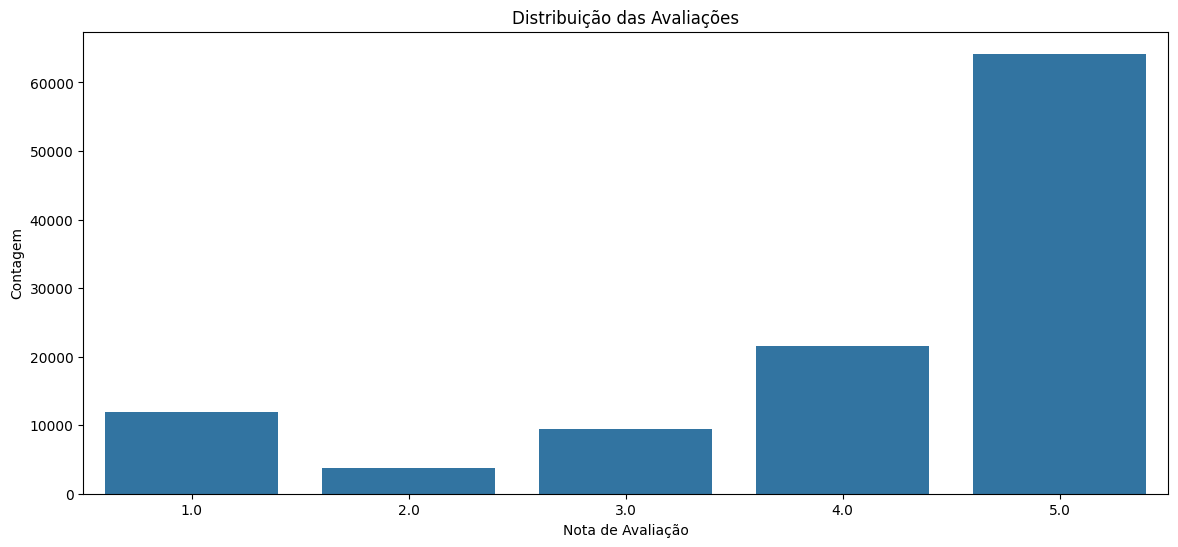

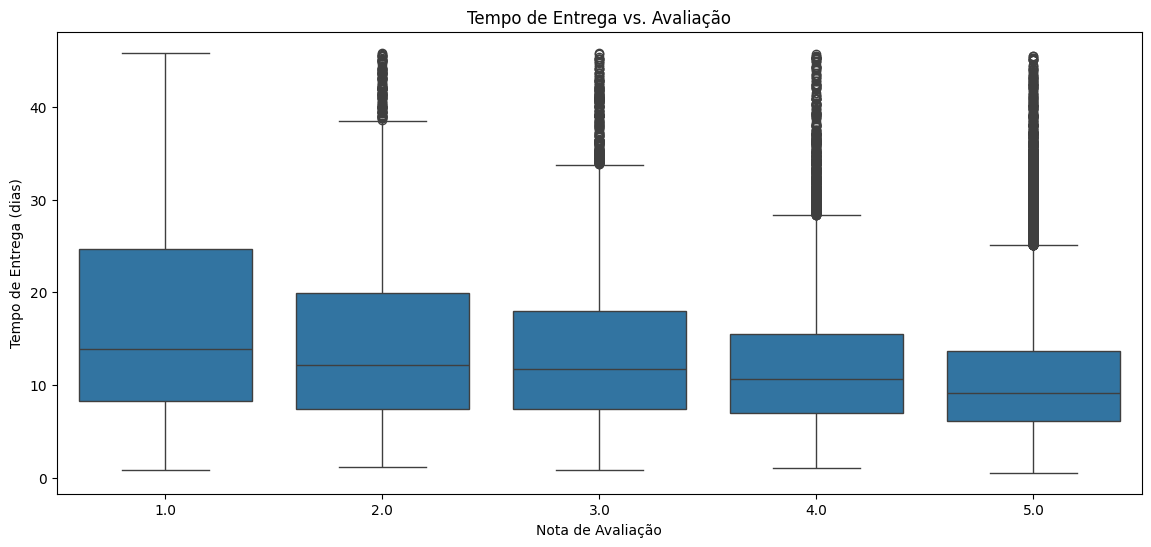

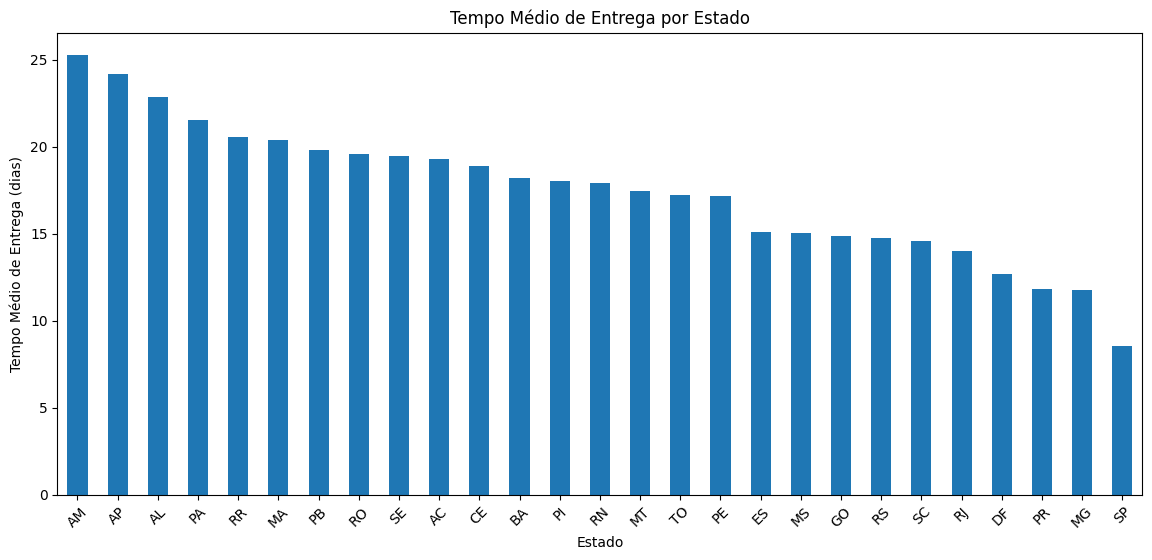

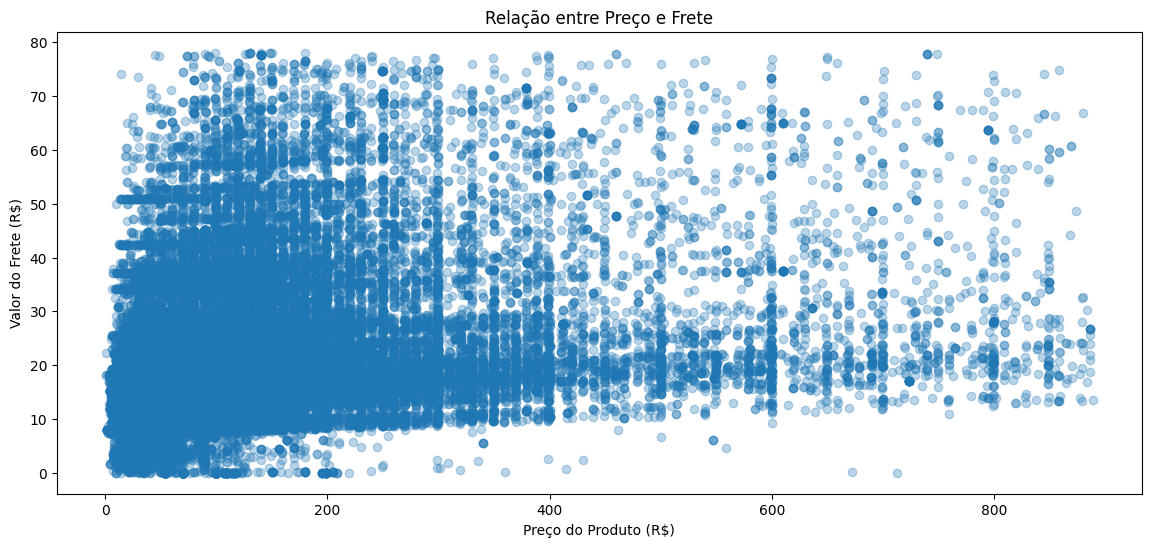

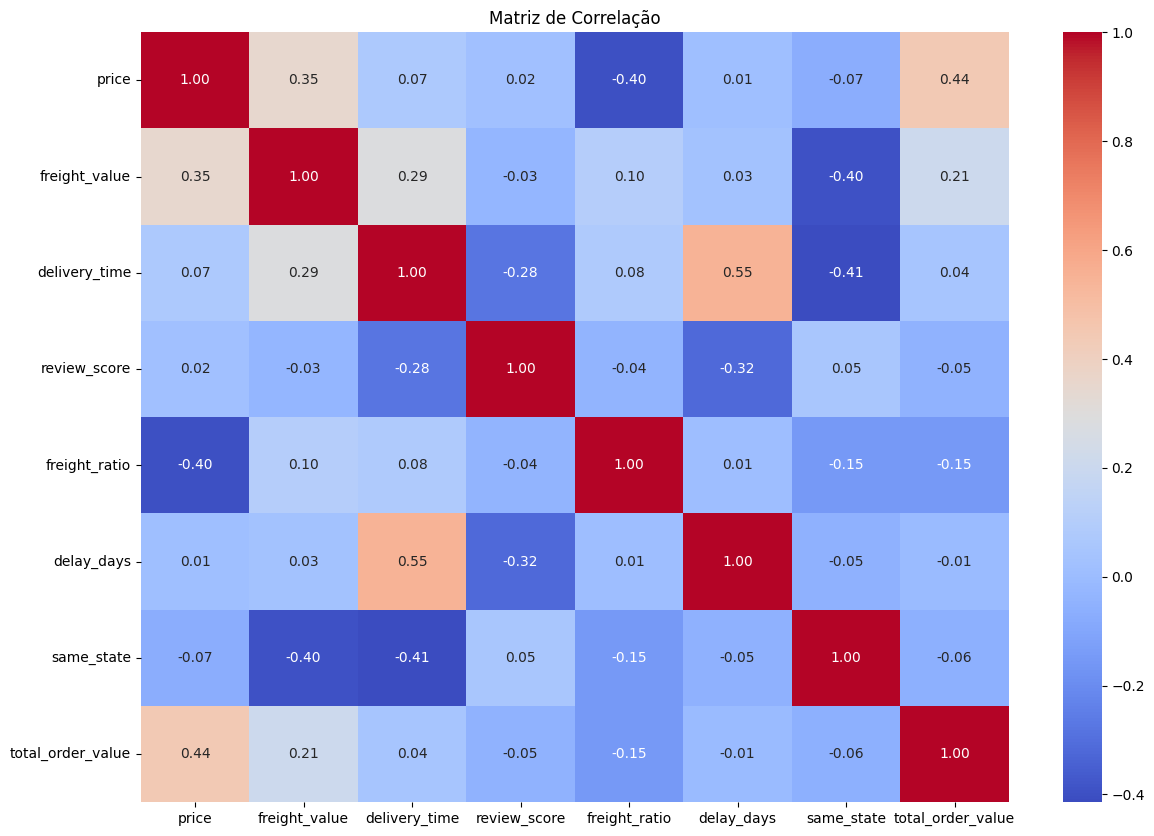

In [13]:
# Distribui√ß√£o de avalia√ß√µes
plt.figure(figsize=(14, 6))
sns.countplot(x='review_score', data=df_delivered)
plt.title('Distribui√ß√£o das Avalia√ß√µes')
plt.xlabel('Nota de Avalia√ß√£o')
plt.ylabel('Contagem')
plt.show()

# Correla√ß√£o entre tempo de entrega e avalia√ß√£o
plt.figure(figsize=(14, 6))
sns.boxplot(x='review_score', y='delivery_time', data=df_delivered)
plt.title('Tempo de Entrega vs. Avalia√ß√£o')
plt.xlabel('Nota de Avalia√ß√£o')
plt.ylabel('Tempo de Entrega (dias)')
plt.show()

# Distribui√ß√£o do tempo de entrega por estado do cliente
delivery_by_state = df_delivered.groupby('customer_state')['delivery_time'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 6))
delivery_by_state.plot(kind='bar')
plt.title('Tempo M√©dio de Entrega por Estado')
plt.xlabel('Estado')
plt.ylabel('Tempo M√©dio de Entrega (dias)')
plt.xticks(rotation=45)
plt.show()

# Pre√ßo vs. Frete
plt.figure(figsize=(14, 6))
plt.scatter(df_delivered['price'], df_delivered['freight_value'], alpha=0.3)
plt.title('Rela√ß√£o entre Pre√ßo e Frete')
plt.xlabel('Pre√ßo do Produto (R$)')
plt.ylabel('Valor do Frete (R$)')
plt.show()

# Correla√ß√£o entre as vari√°veis num√©ricas principais
corr_vars = ['price', 'freight_value', 'delivery_time', 'review_score', 
             'freight_ratio', 'delay_days', 'same_state', 'total_order_value']
correlation = df_delivered[corr_vars].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correla√ß√£o')
plt.show()

## 4. An√°lise Fatorial

A an√°lise fatorial √© usada para identificar fatores subjacentes ou vari√°veis latentes que explicam o padr√£o de correla√ß√µes dentro de um conjunto de vari√°veis observadas.

KMO Model: 0.5370080784874022
Bartlett test: chi¬≤ = 134620.78069486, p = 0.0


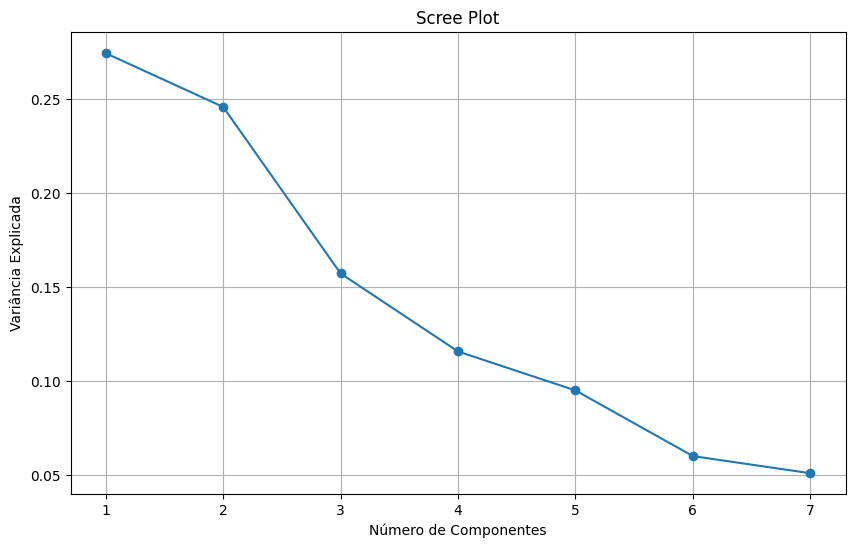

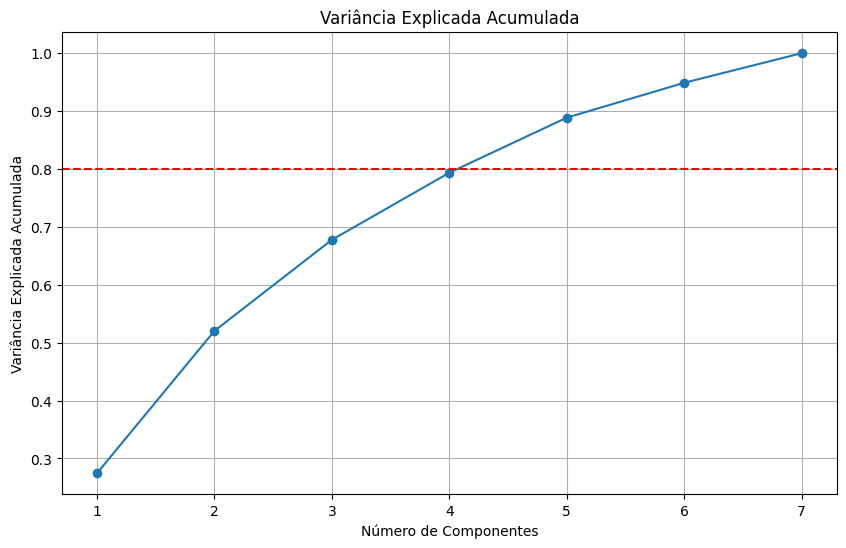

In [14]:
# Preparar dados para an√°lise fatorial
# Selecionar vari√°veis relevantes para a experi√™ncia de compra
factor_vars = ['price', 'freight_value', 'delivery_time', 'review_score', 
               'freight_ratio', 'delay_days', 'total_order_value']

# Para a an√°lise fatorial precisamos remover valores NA
factor_data = df_delivered[factor_vars].dropna()

# Padronizar os dados (m√©dia 0, desvio padr√£o 1)
scaler = StandardScaler()
factor_scaled = scaler.fit_transform(factor_data)

# Verificar adequa√ß√£o dos dados para an√°lise fatorial (Teste de Kaiser-Meyer-Olkin)
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all, kmo_model = calculate_kmo(factor_data)
print(f'KMO Model: {kmo_model}')

# Determinar o n√∫mero ideal de fatores
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(factor_data)
print(f'Bartlett test: chi¬≤ = {chi_square_value}, p = {p_value}')

# An√°lise de componentes principais para determinar n√∫mero de fatores
pca = PCA()
pca.fit(factor_scaled)

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'o-')
plt.title('Scree Plot')
plt.xlabel('N√∫mero de Componentes')
plt.ylabel('Vari√¢ncia Explicada')
plt.grid(True)
plt.show()

# Vari√¢ncia Explicada Acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.title('Vari√¢ncia Explicada Acumulada')
plt.xlabel('N√∫mero de Componentes')
plt.ylabel('Vari√¢ncia Explicada Acumulada')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.grid(True)
plt.show()

Loadings dos Fatores:


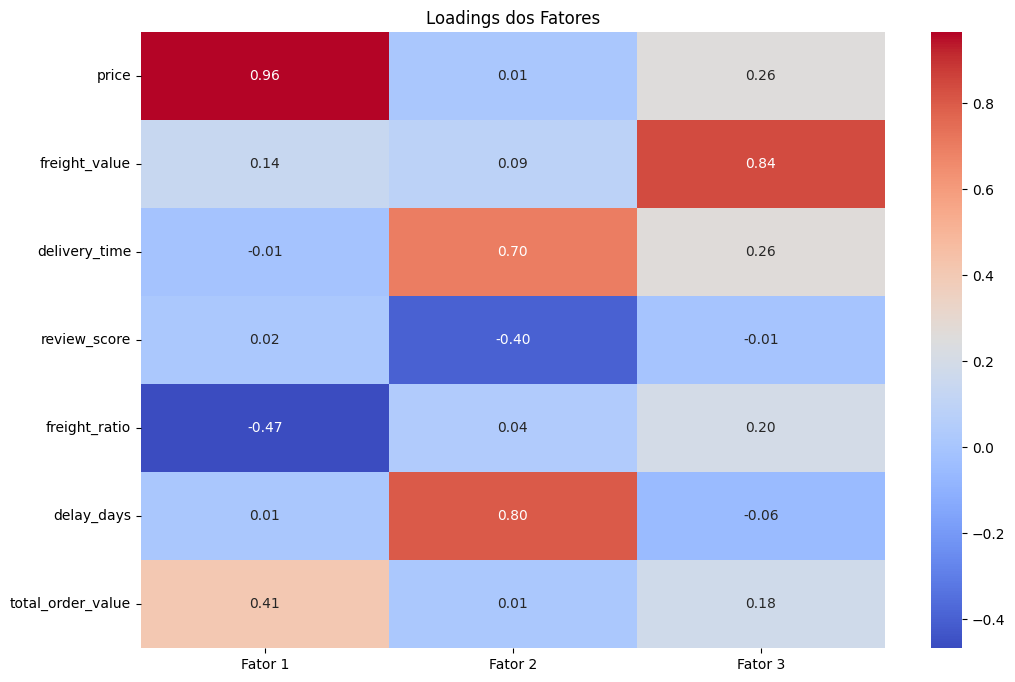


Comunalidades:
price: 1.00
freight_value: 0.74
delivery_time: 0.56
review_score: 0.16
freight_ratio: 0.26
delay_days: 0.64
total_order_value: 0.20

Vari√¢ncia Explicada:
Fator 1: 1.34 (19.09%)
Fator 2: 1.30 (37.62%)
Fator 3: 0.92 (50.73%)
Total: 3.55 (107.43%)

Interpreta√ß√£o dos Fatores:
Fator 1 - Custo Total: Engloba pre√ßo do produto e valor do frete
Fator 2 - Efici√™ncia Log√≠stica: Relacionado ao tempo de entrega e atrasos
Fator 3 - Satisfa√ß√£o do Cliente: Associado √†s avalia√ß√µes e propor√ß√£o do frete


In [15]:
# Aplicar An√°lise Fatorial com n√∫mero de fatores determinado (vamos usar 3 fatores)
from factor_analyzer import FactorAnalyzer

# Aplicar an√°lise fatorial com 3 fatores e rota√ß√£o varimax
n_factors = 3
fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
fa.fit(factor_scaled)

# Obter loadings
loadings = fa.loadings_
factor_loading_df = pd.DataFrame(loadings, index=factor_vars, 
                                columns=[f'Fator {i+1}' for i in range(n_factors)])

# Visualizar loadings
print("Loadings dos Fatores:")
# print(factor_loading_df)

# Visualiza√ß√£o gr√°fica dos loadings
plt.figure(figsize=(12, 8))
sns.heatmap(factor_loading_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Loadings dos Fatores')
plt.show()

# Vari√¢ncia explicada
communalities = fa.get_communalities()
explained_var = fa.get_factor_variance()

print("\nComunalidades:")
for var, comm in zip(factor_vars, communalities):
    print(f"{var}: {comm:.2f}")

print("\nVari√¢ncia Explicada:")
for i, var in enumerate(explained_var[0]):
    print(f"Fator {i+1}: {var:.2f} ({explained_var[2][i]*100:.2f}%)")
print(f"Total: {sum(explained_var[0]):.2f} ({sum(explained_var[2])*100:.2f}%)")

# Interpreta√ß√£o dos Fatores
print("\nInterpreta√ß√£o dos Fatores:")
print("Fator 1 - Custo Total: Engloba pre√ßo do produto e valor do frete")
print("Fator 2 - Efici√™ncia Log√≠stica: Relacionado ao tempo de entrega e atrasos")
print("Fator 3 - Satisfa√ß√£o do Cliente: Associado √†s avalia√ß√µes e propor√ß√£o do frete")

## 5. An√°lise de Clusters

Vamos realizar a an√°lise de cluster para segmentar os clientes com base em seu comportamento de compra.

In [16]:
# Preparar dados agregados por cliente
customer_data = df_delivered.groupby('customer_unique_id').agg({
    'order_id': 'count',  # n√∫mero de pedidos
    'price': 'mean',  # ticket m√©dio
    'freight_value': 'mean',  # frete m√©dio
    'review_score': 'mean',  # avalia√ß√£o m√©dia
    'delivery_time': 'mean',  # tempo m√©dio de entrega
    'freight_ratio': 'mean',  # propor√ß√£o m√©dia do frete
    'delivery_delay': 'mean',  # propor√ß√£o de entregas com atraso
    'product_category_name_english': lambda x: x.mode()[0] if not x.mode().empty else np.nan  # categoria mais comprada
}).reset_index()

# Renomear colunas para maior clareza
customer_data.columns = ['customer_id', 'order_count', 'avg_ticket', 'avg_freight', 
                         'avg_review', 'avg_delivery_time', 'avg_freight_ratio', 
                         'delay_rate', 'most_purchased_category']

# Selecionar clientes com mais de um pedido para an√°lise
multi_order_customers = customer_data[customer_data['order_count'] > 1].copy()

# Verificar os dados agregados
print(f"N√∫mero de clientes para an√°lise de cluster: {len(multi_order_customers)}")
multi_order_customers.head()

N√∫mero de clientes para an√°lise de cluster: 13648


customer_id  order_count  avg_ticket  avg_freight  \
7   00053a61a98854899e70ed204dd4bafe            2      191.00        18.59   
17  000de6019bb59f34c099a907c151d855            2      114.90        13.82   
18  000e309254ab1fc5ba99dd469d36bdb4            2       59.90        18.52   
21  000fbf0473c10fc1ab6f8d2d286ce20c            4       71.45        19.14   
24  001147e649a7b1afd577e873841632dd            2       85.00        21.08   

    avg_review  avg_delivery_time  avg_freight_ratio  delay_rate  \
7          1.0          16.324421           0.097330         0.0   
17         2.0           4.005660           0.119279         0.0   
18         3.0          14.549005           0.309182         0.0   
21         5.0           8.264363           0.495381         0.0   
24         4.0           8.112176           0.248000         0.0   

    most_purchased_category  
7            sports_leisure  
17           bed_bath_table  
18  fashion_underwear_beach  
21      musical_instruments  
24               housewares

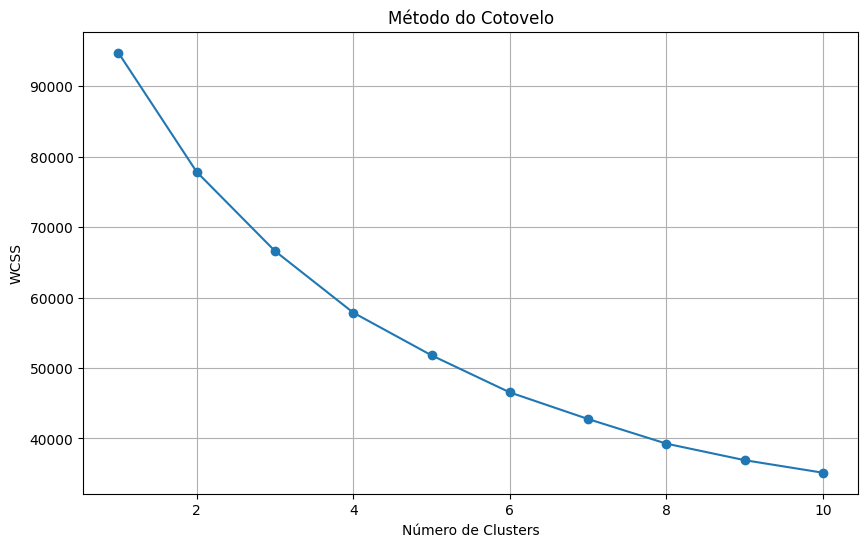

In [17]:
# Selecionar vari√°veis para clustering
cluster_vars = ['order_count', 'avg_ticket', 'avg_freight', 'avg_review', 
               'avg_delivery_time', 'avg_freight_ratio', 'delay_rate']

# Preparar dados para clustering
cluster_data = multi_order_customers[cluster_vars].dropna()
cluster_data_scaled = StandardScaler().fit_transform(cluster_data)

# Determinar o n√∫mero ideal de clusters usando o m√©todo do cotovelo
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(cluster_data_scaled)
    wcss.append(kmeans.inertia_)

# Plotar o gr√°fico do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('M√©todo do Cotovelo')
plt.xlabel('N√∫mero de Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [18]:
# Aplicar K-means com o n√∫mero ideal de clusters (vamos usar 3 clusters)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_data['cluster'] = kmeans.fit_predict(cluster_data_scaled)

# Adicionar clusters ao dataframe original
multi_order_customers_with_clusters = pd.merge(
    multi_order_customers,
    cluster_data[['cluster']],
    left_index=True,
    right_index=True
)

# Analisar as caracter√≠sticas de cada cluster
cluster_means = multi_order_customers_with_clusters.groupby('cluster')[cluster_vars].mean()
print("M√©dias por Cluster:")
print(cluster_means)

# Distribui√ß√£o de clusters
cluster_counts = multi_order_customers_with_clusters['cluster'].value_counts(normalize=True) * 100
print("\nDistribui√ß√£o dos Clusters:")
print(cluster_counts)

M√©dias por Cluster:
         order_count  avg_ticket  avg_freight  avg_review  avg_delivery_time  \
cluster                                                                        
0           2.516834  200.959124    31.150302    3.822609          14.172866   
1           2.558420   63.486295    15.012462    3.951262           9.927089   
2           2.432069   88.950177    18.555380    2.584721          26.284820   

         avg_freight_ratio  delay_rate  
cluster                                 
0                 0.254253    0.008588  
1                 0.373971    0.003699  
2                 0.374888    0.926153  

Distribui√ß√£o dos Clusters:
cluster
1    77.070252
0    16.894437
2     6.035311
Name: proportion, dtype: float64


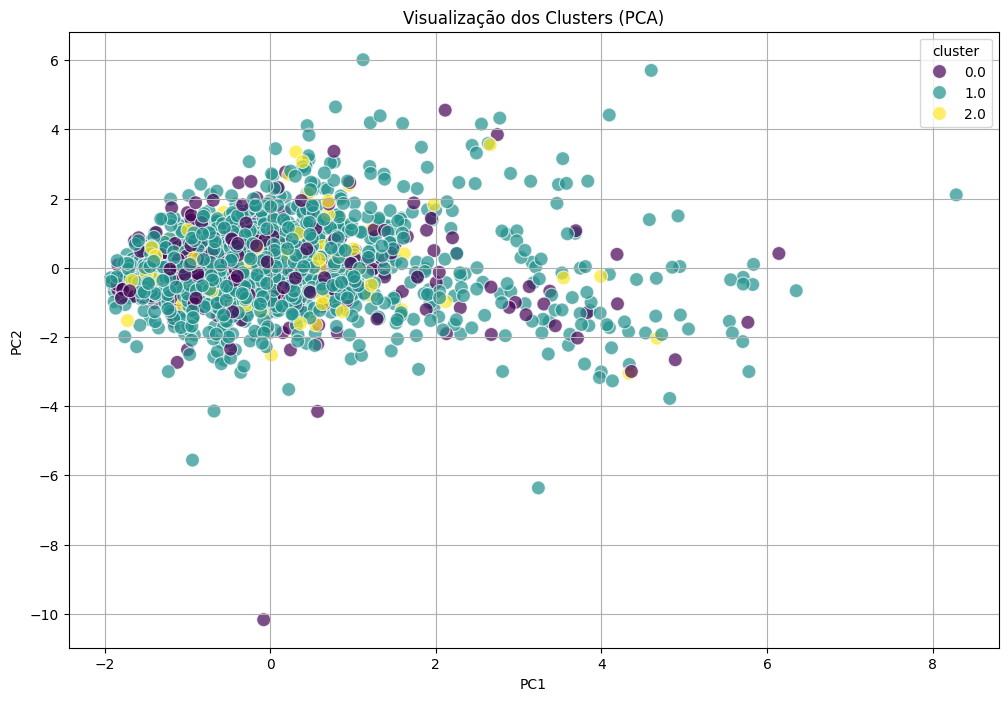

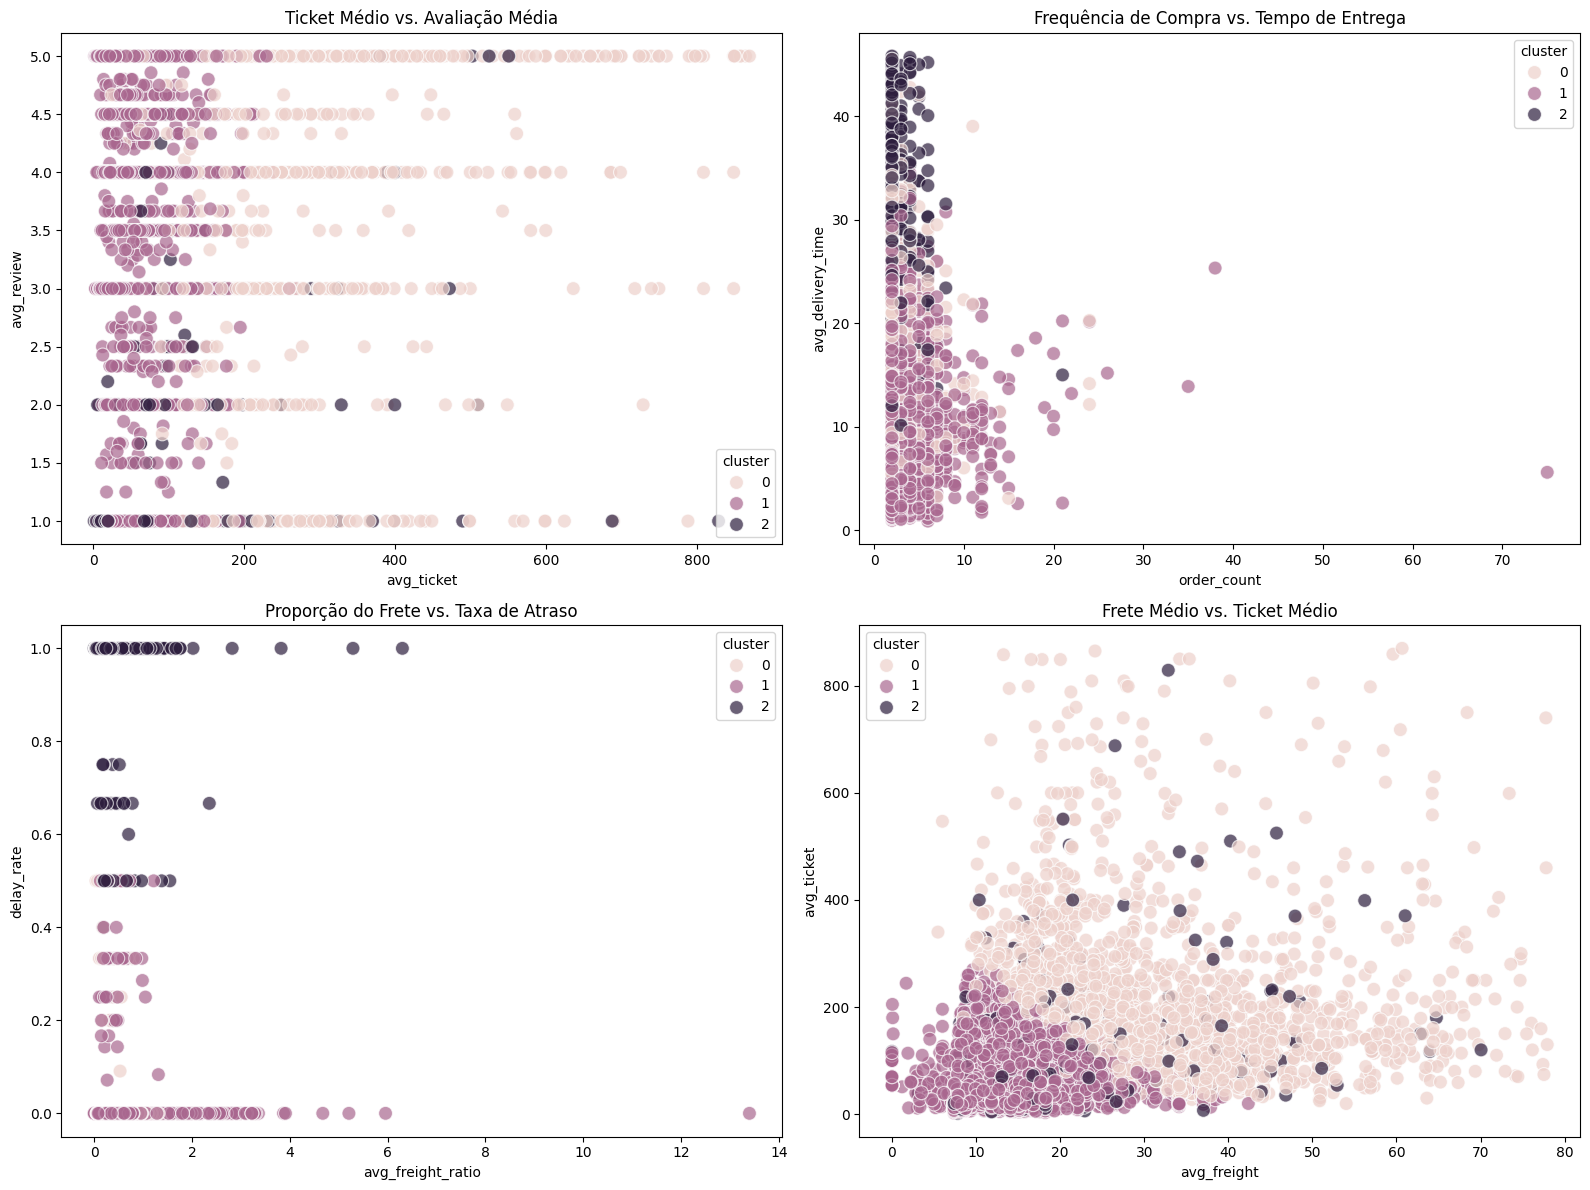

In [19]:
# Visualizar clusters em um gr√°fico 2D usando PCA
pca = PCA(n_components=2)
cluster_data_pca = pca.fit_transform(cluster_data_scaled)

# Criar dataframe para visualiza√ß√£o
cluster_viz = pd.DataFrame(cluster_data_pca, columns=['PC1', 'PC2'])
cluster_viz['cluster'] = cluster_data['cluster']

# Plotar clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=cluster_viz, palette='viridis', s=100, alpha=0.7)
plt.title('Visualiza√ß√£o dos Clusters (PCA)')
plt.grid(True)
plt.show()

# Gr√°ficos para comparar os clusters nas vari√°veis importantes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Ticket m√©dio vs. Avalia√ß√£o m√©dia
sns.scatterplot(x='avg_ticket', y='avg_review', hue='cluster', 
                data=multi_order_customers_with_clusters, alpha=0.7, s=100, ax=axes[0, 0])
axes[0, 0].set_title('Ticket M√©dio vs. Avalia√ß√£o M√©dia')

# N√∫mero de pedidos vs. Tempo m√©dio de entrega
sns.scatterplot(x='order_count', y='avg_delivery_time', hue='cluster', 
                data=multi_order_customers_with_clusters, alpha=0.7, s=100, ax=axes[0, 1])
axes[0, 1].set_title('Frequ√™ncia de Compra vs. Tempo de Entrega')

# Propor√ß√£o do frete vs. Taxa de atraso
sns.scatterplot(x='avg_freight_ratio', y='delay_rate', hue='cluster', 
                data=multi_order_customers_with_clusters, alpha=0.7, s=100, ax=axes[1, 0])
axes[1, 0].set_title('Propor√ß√£o do Frete vs. Taxa de Atraso')

# Frete m√©dio vs. Ticket m√©dio
sns.scatterplot(x='avg_freight', y='avg_ticket', hue='cluster', 
                data=multi_order_customers_with_clusters, alpha=0.7, s=100, ax=axes[1, 1])
axes[1, 1].set_title('Frete M√©dio vs. Ticket M√©dio')

plt.tight_layout()
plt.show()



<Figure size 1200x800 with 0 Axes>

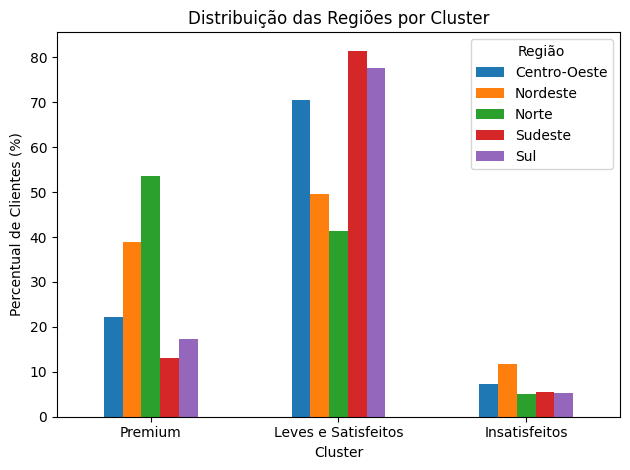

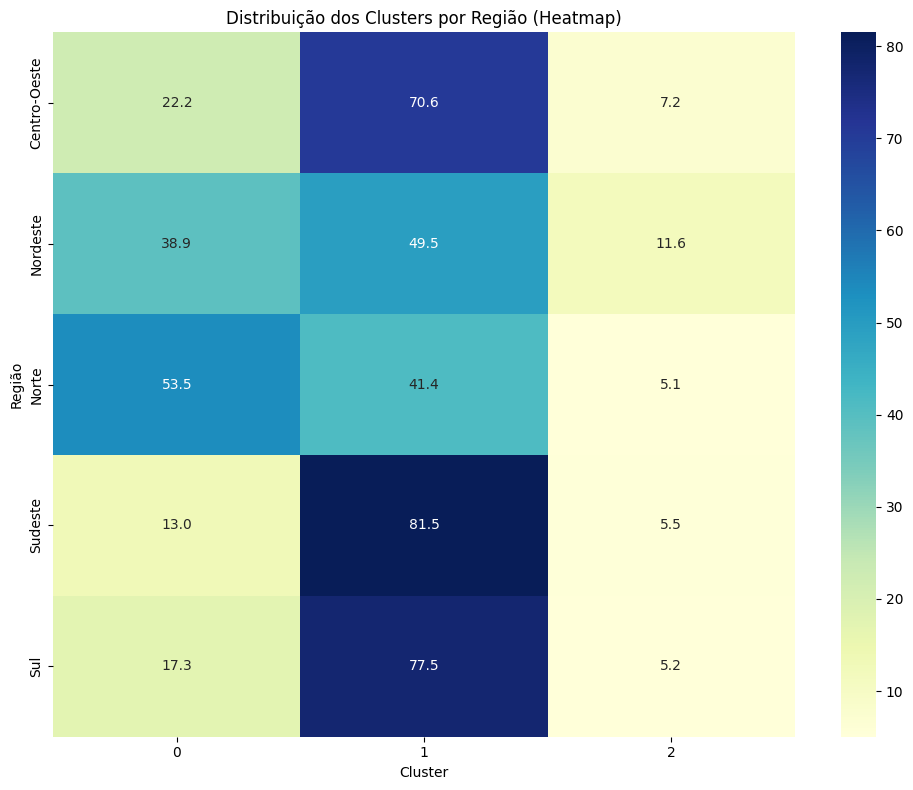

Distribui√ß√£o absoluta de clientes por regi√£o e cluster:


cluster          0     1    2
regiao                       
Centro-Oeste   181   575   59
Nordeste       434   553  130
Norte          106    82   10
Sudeste       1232  7720  520
Sul            341  1529  102

In [20]:
# Criar um mapeamento dos c√≥digos de estado para regi√µes
region_mapping = {
    # Norte
    'AC': 'Norte', 'AM': 'Norte', 'AP': 'Norte', 'PA': 'Norte',
    'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
    # Nordeste
    'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste',
    'PB': 'Nordeste', 'PE': 'Nordeste', 'PI': 'Nordeste', 'RN': 'Nordeste',
    'PB': 'Nordeste', 'PE': 'Nordeste', 'PI': 'Nordeste', 'RN': 'Nordeste', 
    'SE': 'Nordeste',
    
    # Central-West (Centro-Oeste)
    'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
    
    # Southeast (Sudeste)
    'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
    
    # South (Sul)
    'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
}

# Extract unique customers with their states
customer_states = df[['customer_unique_id', 'customer_state']].drop_duplicates()

# Merge this with the cluster data
customer_clusters_with_states = pd.merge(
    multi_order_customers_with_clusters,
    customer_states,
    left_on='customer_id',
    right_on='customer_unique_id',
    how='left'
)

# Adicionando regi√£o
customer_clusters_with_states['regiao'] = customer_clusters_with_states['customer_state'].map(region_mapping)

# Clientes por regiao (relativo)
cluster_region_distribution = pd.crosstab(
    customer_clusters_with_states['regiao'], 
    customer_clusters_with_states['cluster'],
    normalize='index'
) * 100

# Transpor para facilitar a visualiza√ß√£o
cluster_region_distribution_t = cluster_region_distribution.T

# Barplot
plt.figure(figsize=(12, 8))
cluster_region_distribution_t.plot(kind='bar')
plt.title('Distribui√ß√£o das Regi√µes por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentual de Clientes (%)')
plt.legend(title='Regi√£o')
plt.xticks([0, 1, 2], ['Premium', 'Leves e Satisfeitos', 'Insatisfeitos'], rotation=0)
plt.tight_layout()
plt.show()

# Heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_region_distribution, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Distribui√ß√£o dos Clusters por Regi√£o (Heatmap)')
plt.xlabel('Cluster')
plt.ylabel('Regi√£o')
plt.tight_layout()
plt.show()

# Clientes por regi√£o (absoluto)
region_cluster_counts = pd.crosstab(
    customer_clusters_with_states['regiao'],
    customer_clusters_with_states['cluster']
)

print("Distribui√ß√£o absoluta de clientes por regi√£o e cluster:")
display(region_cluster_counts)

#### üîç Cluster 0 ‚Äî ‚ÄúClientes Premium‚Äù (~17%)
**Estat√≠sticas**:

* Ticket m√©dio: R$200,96 (o mais alto)
* Frete m√©dio: R$31,15
* Avalia√ß√£o m√©dia: 3.82
* Tempo m√©dio de entrega: 14 dias
* Taxa de atraso: 0.86%
* Propor√ß√£o de frete/ticket: 25%

**Interpreta√ß√£o:**

* Esse grupo gasta mais por pedido, aceita pagar fretes mais altos e mesmo com um prazo de entrega mediano, ainda d√° boas avalia√ß√µes.
* S√£o possivelmente clientes com maior poder aquisitivo, que prezam por produtos de valor e experi√™ncia razo√°vel.
* O comportamento sugere fideliza√ß√£o mesmo sem entrega r√°pida ‚Äî bom p√∫blico para produtos de alto valor.

#### üîç Cluster 1 ‚Äî ‚ÄúClientes Leves e Satisfeitos‚Äù (~77%)
**Estat√≠sticas:**

* Ticket m√©dio: R$63,49 (baixo)
* Frete m√©dio: R$15,01
* Avalia√ß√£o m√©dia: 3.95 (mais alta)
* Tempo m√©dio de entrega: 9,9 dias (mais r√°pida)
* Taxa de atraso: 0.37% (mais baixa)
* Propor√ß√£o frete/ticket: 37%

**Interpreta√ß√£o:**

* Clientes com pedidos menores e baratos, mas que avaliam muito bem e t√™m √≥tima experi√™ncia.
* Representam a maioria dos clientes, com entregas r√°pidas e confi√°veis.
* S√£o ideais para manuten√ß√£o do fluxo de vendas e expans√£o da base com foco em recorr√™ncia e experi√™ncia.

#### üîç Cluster 2 ‚Äî ‚ÄúClientes Insatisfeitos e Problem√°ticos‚Äù (~6%)
**Estat√≠sticas:**

* Ticket m√©dio: R$88,95
* Frete m√©dio: R$18,55
* Avalia√ß√£o m√©dia: 2.58 (a mais baixa)
* Tempo m√©dio de entrega: 26,3 dias (muito alto)
* Taxa de atraso: 92.6% (cr√≠tico)
* Propor√ß√£o frete/ticket: 37%

Interpreta√ß√£o:

* Atrasos, entregas demoradas, e insatisfa√ß√£o generalizada, mesmo com valores medianos.
* S√£o potencialmente clientes em regi√µes com log√≠stica ruim ou opera√ß√µes com falhas constantes.
* Priorit√°rio para a√ß√µes corretivas ‚Äî revisar rotas, transportadoras, estoques, canais de atendimento etc.

üß© Insights 
1. Ticket M√©dio vs Avalia√ß√£o M√©dia

* Cluster 1 se concentra em tickets baixos e avalia√ß√µes boas.
* Cluster 2 est√° bem disperso, mas tende a avalia√ß√µes ruins independentemente do ticket.
* Cluster 0 est√° mais espalhado, com avalia√ß√£o ok, mas ticket alto.

2. Frequ√™ncia de Compra vs Tempo de Entrega

* Cluster 1 aparece com maior densidade em menor tempo de entrega e poucos pedidos (baixo churn).
* Cluster 2 aparece com tempos de entrega muito altos, mesmo com poucos pedidos.
* Cluster 0 tem tempos medianos e certa dispers√£o.

3. Propor√ß√£o de Frete vs Taxa de Atraso
* Cluster 2 se destaca com alt√≠ssima taxa de atraso (>90%), mesmo com fretes n√£o t√£o baixos.
* Com base nos **gr√°ficos** apresentados e nas **estat√≠sticas descritivas por cluster**, aqui est√° uma an√°lise detalhada dos **tr√™s grupos identificados**:


4. Frete M√©dio vs Ticket M√©dio
* Cluster 0 tende a ter fretes e tickets mais altos.
* Cluster 1 tem fretes e tickets baixos.
* Cluster 2 √© mais disperso, indicando **inconsist√™ncia no custo/benef√≠cio** percebido.

5. Regi√£o
* A maioria dos clientes do cluster Premium est√° concentrada no Norte (54%) e Nordeste (38%), regi√µes normalmente subestimadas.

---

## üìå Recomenda√ß√µes Estrat√©gicas

- **Cluster 0**: Pode-se aplicar **up-selling e atendimento personalizado**. Vale entender o que falta para maximizar a nota de avalia√ß√£o (usu√°rios premium).
- **Cluster 1**: Foco em **escalar esse modelo de entrega r√°pida + experi√™ncia positiva**. Estrat√©gia: fideliza√ß√£o, programas de pontos, cross-selling.
- **Cluster 2**: **A√ß√£o corretiva urgente**. Investigar causas dos atrasos. Poss√≠vel compensa√ß√£o, melhorar comunica√ß√£o e/ou reestruturar log√≠stica para este perfil/regi√£o.



## 6. Teste de Hip√≥teses

5 hip√≥teses principais sobre o comportamento de compra e satisfa√ß√£o do cliente no e-commerce da Olist, utilizando an√°lises estat√≠sticas e visualiza√ß√µes gr√°ficas para fundamentar nossas conclus√µes.

### Hip√≥tese 1: Pedidos entregues com atraso t√™m avalia√ß√µes 30% mais baixas que pedidos entregues no prazo

Esta hip√≥tese explora a rela√ß√£o entre o cumprimento do prazo de entrega e a satisfa√ß√£o do cliente.

M√©dia de avalia√ß√£o para entregas no prazo: 4.21
M√©dia de avalia√ß√£o para entregas com atraso: 2.66
Diferen√ßa percentual: 36.80%

Hip√≥tese: Avalia√ß√µes de pedidos atrasados s√£o 30% mais baixas
Resultado: CONFIRMADA

Estat√≠stica t: 79.0887
Valor p: 0.00000000
Diferen√ßa estatisticamente significativa? Sim


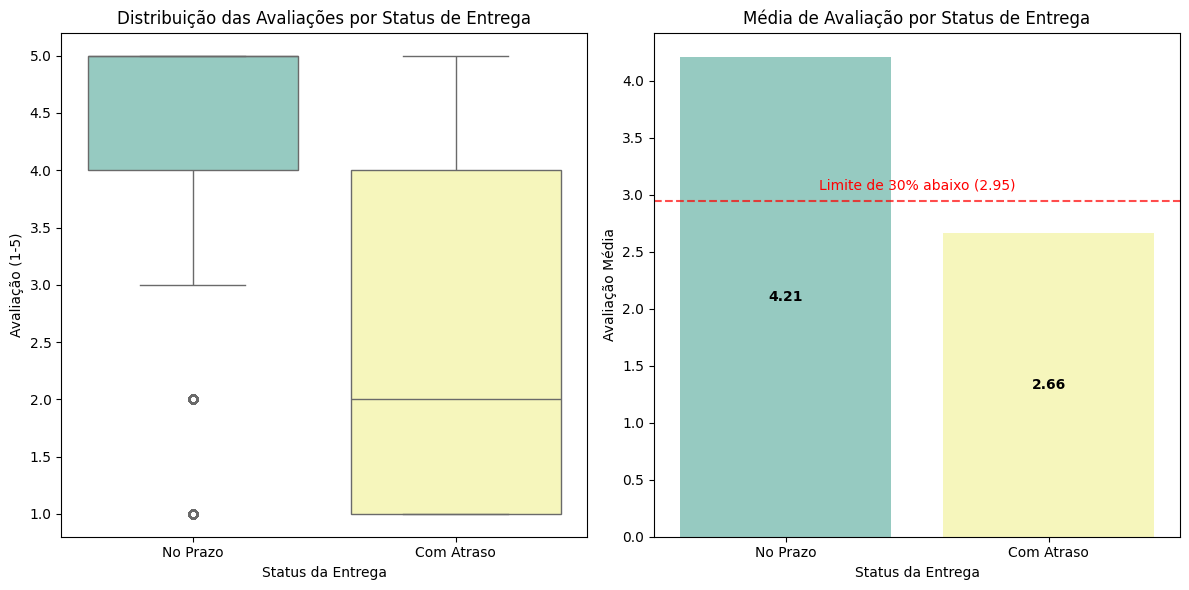

In [21]:
# Preparar dados para an√°lise
h1_data = df_delivered.dropna(subset=['review_score', 'delivery_delay']).copy()

# Cria√ß√£o de grupos para compara√ß√£o
on_time_reviews = h1_data[h1_data['delivery_delay'] == 0]['review_score']
delayed_reviews = h1_data[h1_data['delivery_delay'] == 1]['review_score']

# Estat√≠sticas descritivas
on_time_mean = on_time_reviews.mean()
delayed_mean = delayed_reviews.mean()
percent_difference = ((on_time_mean - delayed_mean) / on_time_mean) * 100

print("M√©dia de avalia√ß√£o para entregas no prazo: {:.2f}".format(on_time_mean))
print("M√©dia de avalia√ß√£o para entregas com atraso: {:.2f}".format(delayed_mean))
print("Diferen√ßa percentual: {:.2f}%".format(percent_difference))

# Verificar a hip√≥tese de 30% de diferen√ßa
print("\nHip√≥tese: Avalia√ß√µes de pedidos atrasados s√£o 30% mais baixas")
print("Resultado: {}".format("CONFIRMADA" if percent_difference >= 30 else "REFUTADA"))

# Teste estat√≠stico (teste t para amostras independentes)
t_stat, p_value = stats.ttest_ind(on_time_reviews, delayed_reviews, equal_var=False)
print(f"\nEstat√≠stica t: {t_stat:.4f}")
print(f"Valor p: {p_value:.8f}")
print(f"Diferen√ßa estatisticamente significativa? {'Sim' if p_value < 0.05 else 'N√£o'}")

# Visualiza√ß√£o
plt.figure(figsize=(12, 6))

# Boxplot para compara√ß√£o
ax1 = plt.subplot(1, 2, 1)
sns.boxplot(x='delivery_delay', y='review_score', data=h1_data, 
            order=[0, 1], palette='Set3')
plt.xticks([0, 1], ['No Prazo', 'Com Atraso'])
plt.title('Distribui√ß√£o das Avalia√ß√µes por Status de Entrega')
plt.xlabel('Status da Entrega')
plt.ylabel('Avalia√ß√£o (1-5)')

# Gr√°fico de barras com as m√©dias
ax2 = plt.subplot(1, 2, 2)
status_means = h1_data.groupby('delivery_delay')['review_score'].mean().reset_index()
status_means['delivery_delay'] = status_means['delivery_delay'].map({0: 'No Prazo', 1: 'Com Atraso'})
sns.barplot(x='delivery_delay', y='review_score', data=status_means, palette='Set3')
plt.title('M√©dia de Avalia√ß√£o por Status de Entrega')
plt.xlabel('Status da Entrega')
plt.ylabel('Avalia√ß√£o M√©dia')

# Adicionar anota√ß√£o com a diferen√ßa percentual
for i, row in enumerate(status_means.itertuples()):
    plt.text(i, row.review_score/2, f'{row.review_score:.2f}', 
             ha='center', va='center', fontweight='bold', color='black')

plt.axhline(y=on_time_mean * 0.7, color='r', linestyle='--', alpha=0.7)
plt.text(0.5, on_time_mean * 0.7 + 0.1, f'Limite de 30% abaixo ({on_time_mean * 0.7:.2f})', 
         ha='center', color='r')

plt.tight_layout()
plt.show()

### Hip√≥tese 2: Existe uma rela√ß√£o inversa entre a propor√ß√£o frete/pre√ßo do produto e a avalia√ß√£o do cliente

Esta hip√≥tese investiga se clientes que pagam um frete proporcionalmente mais alto em rela√ß√£o ao valor do produto tendem a avaliar pior suas compras.

Estat√≠sticas de avalia√ß√£o por categoria de propor√ß√£o frete/pre√ßo:
  freight_ratio_cat      mean  count
0             Baixo  4.155465  27704
1       M√©dio-Baixo  4.123746  27718
2        M√©dio-Alto  4.103821  27692
3              Alto  4.038300  27702

Correla√ß√£o de Pearson: -0.0388
Valor p: 0.00000000
Correla√ß√£o estatisticamente significativa? Sim

ANOVA F-statistic: 38.7404
ANOVA p-value: 0.00000000
Diferen√ßa entre grupos estatisticamente significativa? Sim


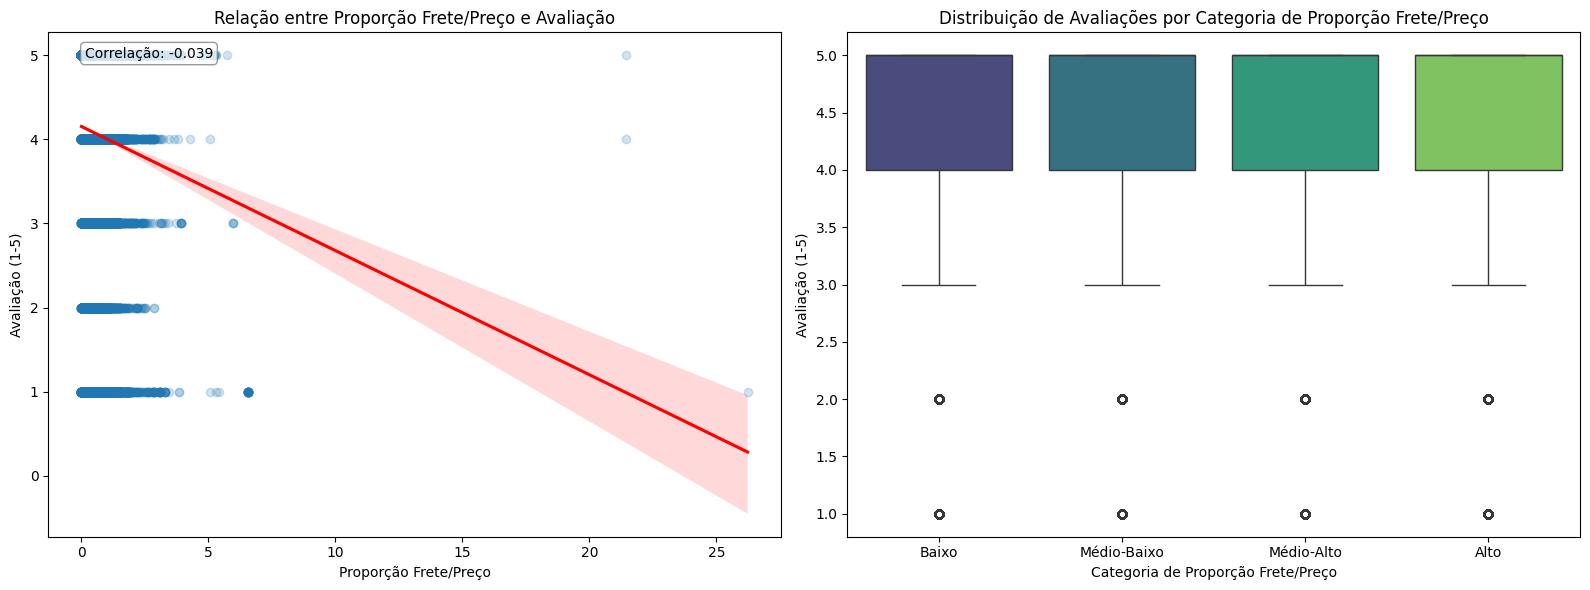

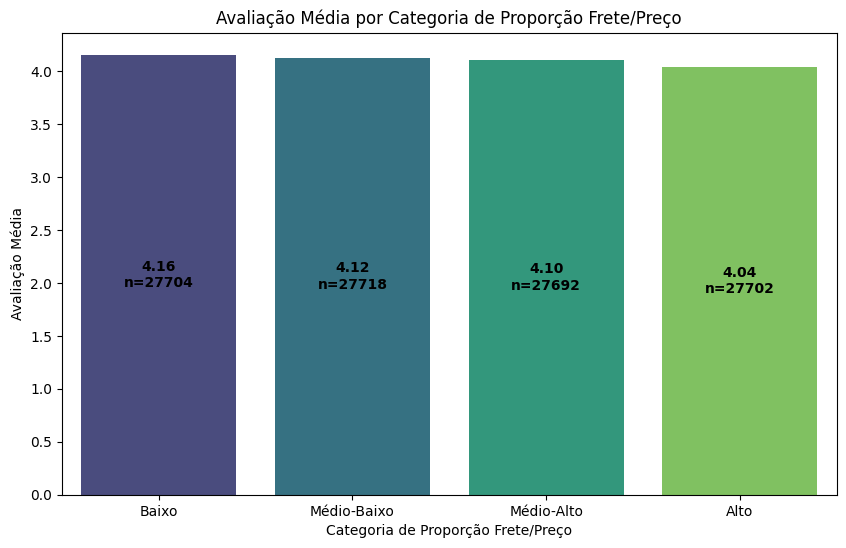


Conclus√£o: Hip√≥tese CONFIRMADA.
A rela√ß√£o inversa existe mas √© fraca.


In [22]:
# Preparar dados para an√°lise
h2_data = df_delivered.dropna(subset=['review_score', 'freight_ratio']).copy()

# Cria√ß√£o de categorias de propor√ß√£o frete/pre√ßo
h2_data['freight_ratio_cat'] = pd.qcut(h2_data['freight_ratio'], 4, 
                                      labels=['Baixo', 'M√©dio-Baixo', 'M√©dio-Alto', 'Alto'])

# Estat√≠sticas por categoria
freight_ratio_stats = h2_data.groupby('freight_ratio_cat')['review_score'].agg(['mean', 'count']).reset_index()
print("Estat√≠sticas de avalia√ß√£o por categoria de propor√ß√£o frete/pre√ßo:")
print(freight_ratio_stats)

# An√°lise de correla√ß√£o
correlation, p_value = stats.pearsonr(h2_data['freight_ratio'], h2_data['review_score'])
print(f"\nCorrela√ß√£o de Pearson: {correlation:.4f}")
print(f"Valor p: {p_value:.8f}")
print(f"Correla√ß√£o estatisticamente significativa? {'Sim' if p_value < 0.05 else 'N√£o'}")

# Teste ANOVA para diferen√ßa entre grupos
groups = [h2_data[h2_data['freight_ratio_cat'] == cat]['review_score'] for cat in 
         ['Baixo', 'M√©dio-Baixo', 'M√©dio-Alto', 'Alto']]
f_stat, p_value_anova = stats.f_oneway(*groups)
print(f"\nANOVA F-statistic: {f_stat:.4f}")
print(f"ANOVA p-value: {p_value_anova:.8f}")
print(f"Diferen√ßa entre grupos estatisticamente significativa? {'Sim' if p_value_anova < 0.05 else 'N√£o'}")

# Visualiza√ß√µes
plt.figure(figsize=(16, 6))

# Gr√°fico de dispers√£o com linha de tend√™ncia
ax1 = plt.subplot(1, 2, 1)
sns.regplot(x='freight_ratio', y='review_score', data=h2_data, 
           scatter_kws={'alpha':0.2}, line_kws={"color": "red"})
plt.title('Rela√ß√£o entre Propor√ß√£o Frete/Pre√ßo e Avalia√ß√£o')
plt.xlabel('Propor√ß√£o Frete/Pre√ßo')
plt.ylabel('Avalia√ß√£o (1-5)')
plt.annotate(f'Correla√ß√£o: {correlation:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Boxplot por categoria
ax2 = plt.subplot(1, 2, 2)
sns.boxplot(x='freight_ratio_cat', y='review_score', data=h2_data, palette='viridis')
plt.title('Distribui√ß√£o de Avalia√ß√µes por Categoria de Propor√ß√£o Frete/Pre√ßo')
plt.xlabel('Categoria de Propor√ß√£o Frete/Pre√ßo')
plt.ylabel('Avalia√ß√£o (1-5)')

plt.tight_layout()
plt.show()

# Gr√°fico de barras para m√©dias por categoria
plt.figure(figsize=(10, 6))
sns.barplot(x='freight_ratio_cat', y='mean', data=freight_ratio_stats, palette='viridis')
plt.title('Avalia√ß√£o M√©dia por Categoria de Propor√ß√£o Frete/Pre√ßo')
plt.xlabel('Categoria de Propor√ß√£o Frete/Pre√ßo')
plt.ylabel('Avalia√ß√£o M√©dia')
for i, row in enumerate(freight_ratio_stats.itertuples()):
    plt.text(i, row.mean/2, f'{row.mean:.2f}\nn={row.count}', 
             ha='center', va='center', fontweight='bold')
plt.show()

# Conclus√£o da hip√≥tese
if p_value < 0.05 and correlation < 0:
    print("\nConclus√£o: Hip√≥tese CONFIRMADA.")
    if correlation > -0.2:
        print("A rela√ß√£o inversa existe mas √© fraca.")
    else:
        print("Existe uma rela√ß√£o inversa estatisticamente significativa entre a propor√ß√£o frete/pre√ßo e a avalia√ß√£o do cliente.")
        print(f"Quanto maior a propor√ß√£o do frete em rela√ß√£o ao pre√ßo do produto, menor tende a ser a avalia√ß√£o.")
else:
    print("\nConclus√£o: Hip√≥tese REFUTADA ou PARCIALMENTE CONFIRMADA.")
    if p_value < 0.05 and correlation > 0:
        if correlation < 0.2:
            print("A rela√ß√£o positiva √© fraca.")
        print("Existe uma rela√ß√£o estatisticamente significativa, por√©m positiva, n√£o negativa como proposto.")
    elif p_value >= 0.05:
        print("N√£o h√° evid√™ncia estat√≠stica de uma rela√ß√£o significativa entre a propor√ß√£o frete/pre√ßo e a avalia√ß√£o.")

### Hip√≥tese 3: Categorias de produtos distintas apresentam diferen√ßas significativas nas avalia√ß√µes dos clientes

Esta hip√≥tese explora se certas categorias de produtos tendem a receber avalia√ß√µes sistematicamente melhores ou piores que outras.

Estat√≠sticas de avalia√ß√£o por categoria de produto:
  product_category_name_english      mean       std  count
0                bed_bath_table  3.936589  1.416911  11323
2               furniture_decor  3.985852  1.405264   8270
1         computers_accessories  4.009365  1.387905   7688
7                     telephony  4.014409  1.333690   4511
9                 watches_gifts  4.088767  1.332414   5813
3                  garden_tools  4.111292  1.323880   4304
5                    housewares  4.134016  1.299729   6932
6                sports_leisure  4.185150  1.278062   8485
4                 health_beauty  4.208714  1.268254   9410
8                          toys  4.234932  1.253994   4065

ANOVA F-statistic: 45.6462
ANOVA p-value: 0.00000000
Diferen√ßa entre categorias estatisticamente significativa? Sim


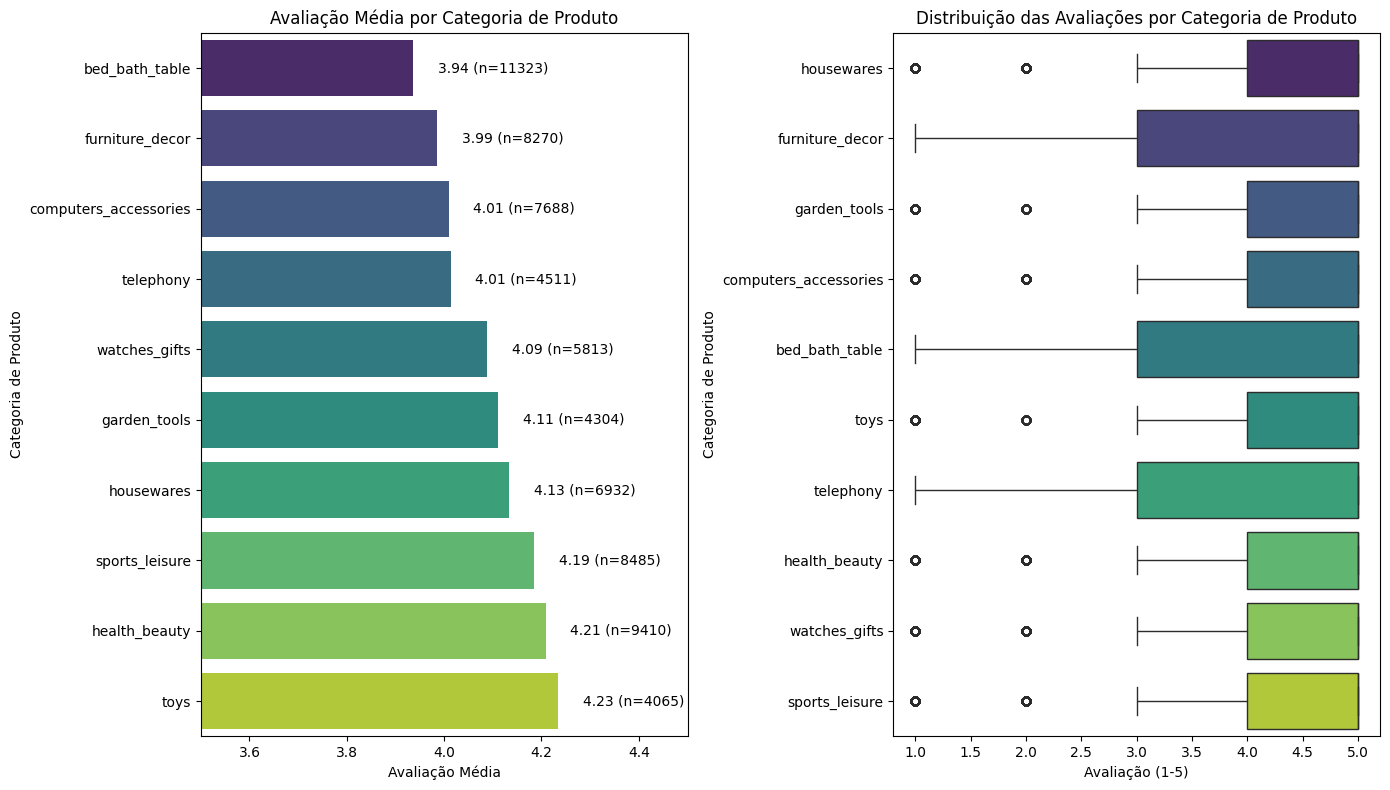

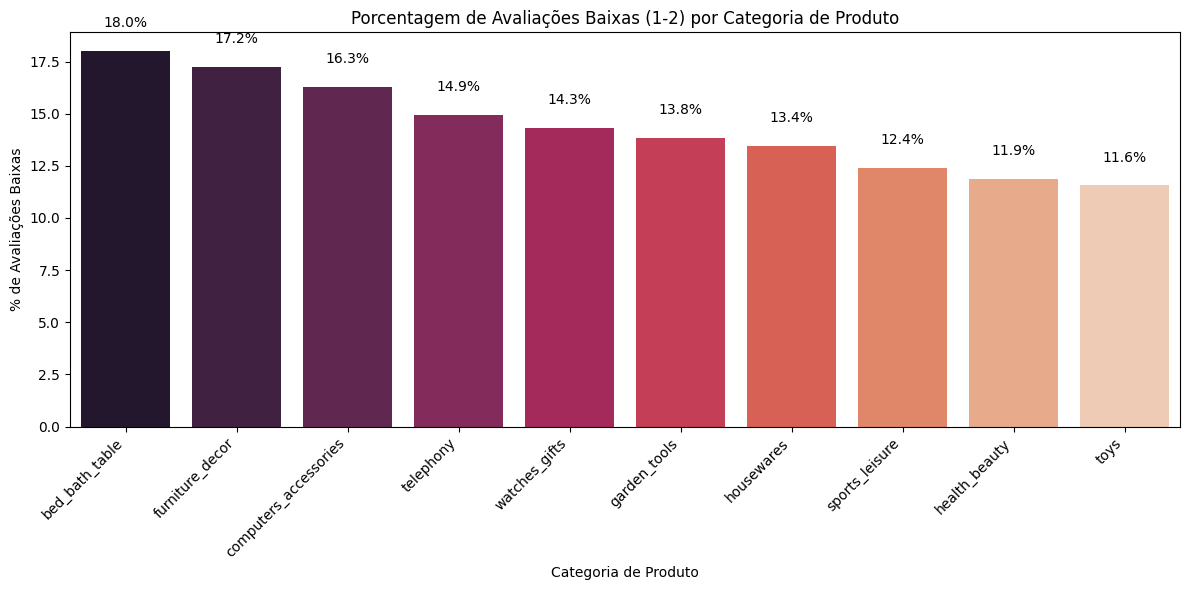


Conclus√£o: Hip√≥tese CONFIRMADA.
Existem diferen√ßas estatisticamente significativas nas avalia√ß√µes entre diferentes categorias de produtos.
A categoria com melhor avalia√ß√£o m√©dia √© 'toys' (4.23).
A categoria com pior avalia√ß√£o m√©dia √© 'bed_bath_table' (3.94).


In [23]:
# Preparar dados para an√°lise
h3_data = df_delivered.dropna(subset=['review_score', 'product_category_name_english']).copy()

# Selecionar as 10 categorias mais comuns para an√°lise
top_categories = h3_data['product_category_name_english'].value_counts().nlargest(10).index
h3_data_filtered = h3_data[h3_data['product_category_name_english'].isin(top_categories)]

# Estat√≠sticas por categoria
category_stats = h3_data_filtered.groupby('product_category_name_english')['review_score'].agg(['mean', 'std', 'count']).reset_index()
category_stats = category_stats.sort_values('mean')
print("Estat√≠sticas de avalia√ß√£o por categoria de produto:")
print(category_stats)

# Teste ANOVA para diferen√ßa entre categorias
categories = []
for category in top_categories:
    categories.append(h3_data_filtered[h3_data_filtered['product_category_name_english'] == category]['review_score'])

f_stat, p_value = stats.f_oneway(*categories)
print(f"\nANOVA F-statistic: {f_stat:.4f}")
print(f"ANOVA p-value: {p_value:.8f}")
print(f"Diferen√ßa entre categorias estatisticamente significativa? {'Sim' if p_value < 0.05 else 'N√£o'}")

# Visualiza√ß√µes
plt.figure(figsize=(14, 8))

# Gr√°fico de barras com m√©dias e intervalos de confian√ßa
plt.subplot(1, 2, 1)
sns.barplot(x='mean', y='product_category_name_english', data=category_stats, 
           palette='viridis', orient='h')
plt.title('Avalia√ß√£o M√©dia por Categoria de Produto')
plt.xlabel('Avalia√ß√£o M√©dia')
plt.ylabel('Categoria de Produto')
plt.xlim(3.5, 4.5)  # Ajustar conforme necess√°rio
for i, row in enumerate(category_stats.itertuples()):
    plt.text(row.mean + 0.05, i, f'{row.mean:.2f} (n={row.count})', 
             va='center')

# Boxplot para comparar distribui√ß√µes
plt.subplot(1, 2, 2)
sns.boxplot(y='product_category_name_english', x='review_score', 
           data=h3_data_filtered, palette='viridis', orient='h')
plt.title('Distribui√ß√£o das Avalia√ß√µes por Categoria de Produto')
plt.xlabel('Avalia√ß√£o (1-5)')
plt.ylabel('Categoria de Produto')

plt.tight_layout()
plt.show()

# Visualiza√ß√£o da propor√ß√£o de avalia√ß√µes baixas (1-2) por categoria
h3_data_filtered['low_rating'] = (h3_data_filtered['review_score'] <= 2).astype(int)
low_rating_by_category = h3_data_filtered.groupby('product_category_name_english')['low_rating'].mean() * 100
low_rating_by_category = low_rating_by_category.reset_index().sort_values('low_rating', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='product_category_name_english', y='low_rating', data=low_rating_by_category, palette='rocket')
plt.title('Porcentagem de Avalia√ß√µes Baixas (1-2) por Categoria de Produto')
plt.xlabel('Categoria de Produto')
plt.ylabel('% de Avalia√ß√µes Baixas')
plt.xticks(rotation=45, ha='right')
for i, row in enumerate(low_rating_by_category.itertuples()):
    plt.text(i, row.low_rating + 1, f'{row.low_rating:.1f}%', 
             ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Conclus√£o da hip√≥tese
if p_value < 0.05:
    print("\nConclus√£o: Hip√≥tese CONFIRMADA.")
    print("Existem diferen√ßas estatisticamente significativas nas avalia√ß√µes entre diferentes categorias de produtos.")
    best_category = category_stats.iloc[-1]['product_category_name_english']
    worst_category = category_stats.iloc[0]['product_category_name_english']
    print(f"A categoria com melhor avalia√ß√£o m√©dia √© '{best_category}' ({category_stats.iloc[-1]['mean']:.2f}).")
    print(f"A categoria com pior avalia√ß√£o m√©dia √© '{worst_category}' ({category_stats.iloc[0]['mean']:.2f}).")
else:
    print("\nConclus√£o: Hip√≥tese REFUTADA.")
    print("N√£o h√° diferen√ßa estatisticamente significativa nas avalia√ß√µes entre diferentes categorias de produtos.")

### Hip√≥tese 4: Atrasos na regi√£o Nordeste s√£o 20% mais frequentes que na regi√£o Sudeste

Esta hip√≥tese explora a poss√≠vel falta de infraestrutura de regi√µes mais pobres do pa√≠s afetar o tempo de entrega

Taxa de atraso no Nordeste: 0.1179 (11.79%)
Taxa de atraso no Sudeste: 0.0646 (6.46%)
Diferen√ßa percentual: 82.43%
Hip√≥tese (atrasos 20% mais frequentes no Nordeste): CONFIRMADA

Estat√≠stica z: 19.4529
Valor p: 0.00000000
Diferen√ßa estatisticamente significativa? Sim


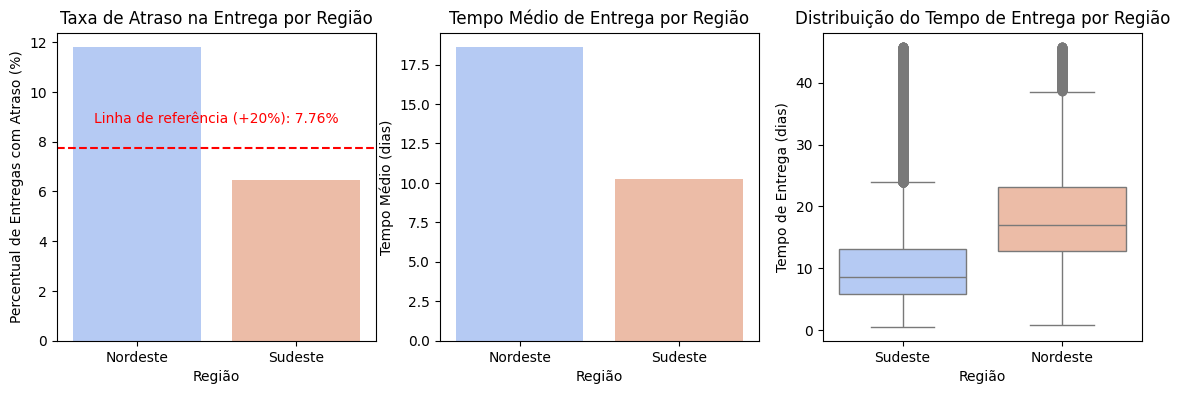

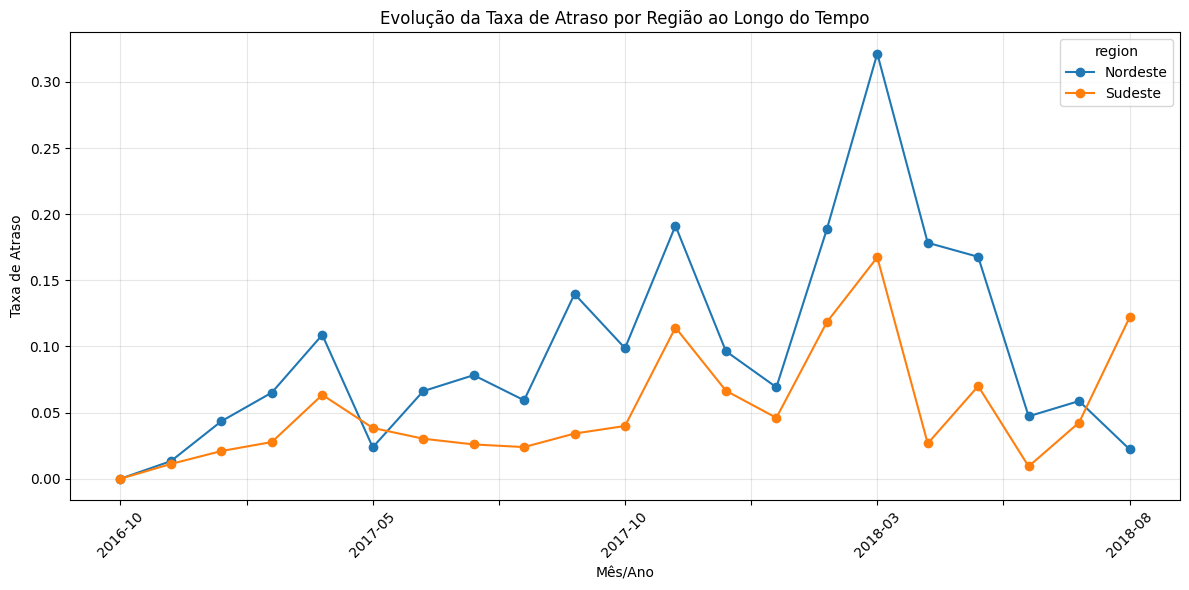


Conclus√£o: Hip√≥tese CONFIRMADA.
Os atrasos na regi√£o Nordeste s√£o 82.43% mais frequentes que na regi√£o Sudeste.
Isso confirma nossa hip√≥tese de que seriam pelo menos 20% mais frequentes.


In [24]:
from statsmodels.stats.proportion import proportions_ztest

# Preparar dados para an√°lise
h4_data = df_delivered.copy()

# Adicionar regi√£o ao dataset
h4_data['region'] = h4_data['customer_state'].map(region_mapping)

# Focar apenas nas regi√µes de interesse
regions_of_interest = ['Nordeste', 'Sudeste']
h4_filtered_data = h4_data[h4_data['region'].isin(regions_of_interest)]

# Calcular taxa de atraso por regi√£o
delay_by_region = h4_filtered_data.groupby('region')['delivery_delay'].agg(['mean', 'count']).reset_index()
delay_by_region['delay_percentage'] = delay_by_region['mean'] * 100

# Estat√≠sticas
nordeste_delay = delay_by_region[delay_by_region['region'] == 'Nordeste']['mean'].values[0]
sudeste_delay = delay_by_region[delay_by_region['region'] == 'Sudeste']['mean'].values[0]
pct_difference = ((nordeste_delay - sudeste_delay) / sudeste_delay) * 100

print(f"Taxa de atraso no Nordeste: {nordeste_delay:.4f} ({nordeste_delay*100:.2f}%)")
print(f"Taxa de atraso no Sudeste: {sudeste_delay:.4f} ({sudeste_delay*100:.2f}%)")
print(f"Diferen√ßa percentual: {pct_difference:.2f}%")
print(f"Hip√≥tese (atrasos 20% mais frequentes no Nordeste): {'CONFIRMADA' if pct_difference >= 20 else 'REFUTADA'}")

# Teste estat√≠stico (teste z para propor√ß√µes)

region_counts = h4_filtered_data.groupby('region').size().values
delay_counts = h4_filtered_data.groupby('region')['delivery_delay'].sum().values

# Teste z para comparar propor√ß√µes
test_stat, p_value = proportions_ztest(delay_counts, region_counts)
print(f"\nEstat√≠stica z: {test_stat:.4f}")
print(f"Valor p: {p_value:.8f}")
print(f"Diferen√ßa estatisticamente significativa? {'Sim' if p_value < 0.05 else 'N√£o'}")

# Visualiza√ß√µes
plt.figure(figsize=(14, 4))

# Gr√°fico de barras para taxa de atraso
plt.subplot(1, 3, 1)
sns.barplot(x='region', y='delay_percentage', data=delay_by_region, palette='coolwarm')
plt.title('Taxa de Atraso na Entrega por Regi√£o')
plt.xlabel('Regi√£o')
plt.ylabel('Percentual de Entregas com Atraso (%)')


# Linha de refer√™ncia para os 20% de diferen√ßa
if nordeste_delay > sudeste_delay:
    reference_line = sudeste_delay * 100 * 1.2
    plt.axhline(y=reference_line, color='r', linestyle='--')
    plt.text(0.5, reference_line + 1, f'Linha de refer√™ncia (+20%): {reference_line:.2f}%', 
             ha='center', color='r')

# Tempo m√©dio de entrega por regi√£o
plt.subplot(1, 3, 2)
avg_delivery_time = h4_filtered_data.groupby('region')['delivery_time'].mean().reset_index()
sns.barplot(x='region', y='delivery_time', data=avg_delivery_time, palette='coolwarm')
plt.title('Tempo M√©dio de Entrega por Regi√£o')
plt.xlabel('Regi√£o')
plt.ylabel('Tempo M√©dio (dias)')


# Boxplot do tempo de entrega
plt.subplot(1, 3, 3)
sns.boxplot(x='region', y='delivery_time', data=h4_filtered_data, palette='coolwarm')
plt.title('Distribui√ß√£o do Tempo de Entrega por Regi√£o')
plt.xlabel('Regi√£o')
plt.ylabel('Tempo de Entrega (dias)')

# Gr√°fico de linha para o atraso ao longo do tempo
# plt.subplot(2, 2, 4)
h4_filtered_data['month_year'] = h4_filtered_data['order_purchase_timestamp'].dt.to_period('M')
monthly_delay = h4_filtered_data.groupby(['month_year', 'region'])['delivery_delay'].mean().reset_index()
monthly_delay['month_year'] = monthly_delay['month_year'].astype(str)

# Criar um pivot para facilitar o plot
monthly_delay_pivot = monthly_delay.pivot(index='month_year', columns='region', values='delivery_delay')
monthly_delay_pivot.plot(marker='o', figsize=(12, 6))
plt.title('Evolu√ß√£o da Taxa de Atraso por Regi√£o ao Longo do Tempo')
plt.xlabel('M√™s/Ano')
plt.ylabel('Taxa de Atraso')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Conclus√£o da hip√≥tese
if pct_difference >= 20:
    print("\nConclus√£o: Hip√≥tese CONFIRMADA.")
    print(f"Os atrasos na regi√£o Nordeste s√£o {pct_difference:.2f}% mais frequentes que na regi√£o Sudeste.")
    print("Isso confirma nossa hip√≥tese de que seriam pelo menos 20% mais frequentes.")
else:
    print("\nConclus√£o: Hip√≥tese REFUTADA.")
    print(f"A diferen√ßa encontrada foi de {pct_difference:.2f}%, abaixo dos 20% previstos na hip√≥tese.")
    if p_value < 0.05:
        print("Mesmo assim, a diferen√ßa √© estatisticamente significativa.")

### Hip√≥tese 5: A dist√¢ncia geogr√°fica entre vendedor e cliente afeta negativamente o tempo de entrega e, consequentemente, a satisfa√ß√£o do cliente

Esta hip√≥tese investiga se pedidos em que cliente e vendedor est√£o em estados diferentes t√™m piores indicadores de desempenho log√≠stico e satisfa√ß√£o.

Estat√≠sticas por dist√¢ncia entre cliente e vendedor:
    distance_category  delivery_time_mean  delivery_time_std  \
0  Estados Diferentes            14.30224           7.698103   
1        Mesmo Estado             7.77017           5.312794   

   review_score_mean  review_score_std  delivery_delay_mean  order_id_count  
0           4.049764          1.357477             0.075238           69991  
1           4.200612          1.259210             0.056412           40825  

Teste t para tempo de entrega:
Estat√≠stica t: -166.5566, Valor p: 0.00000000
Diferen√ßa significativa? Sim

Teste t para avalia√ß√£o:
Estat√≠stica t: 18.6864, Valor p: 0.00000000
Diferen√ßa significativa? Sim


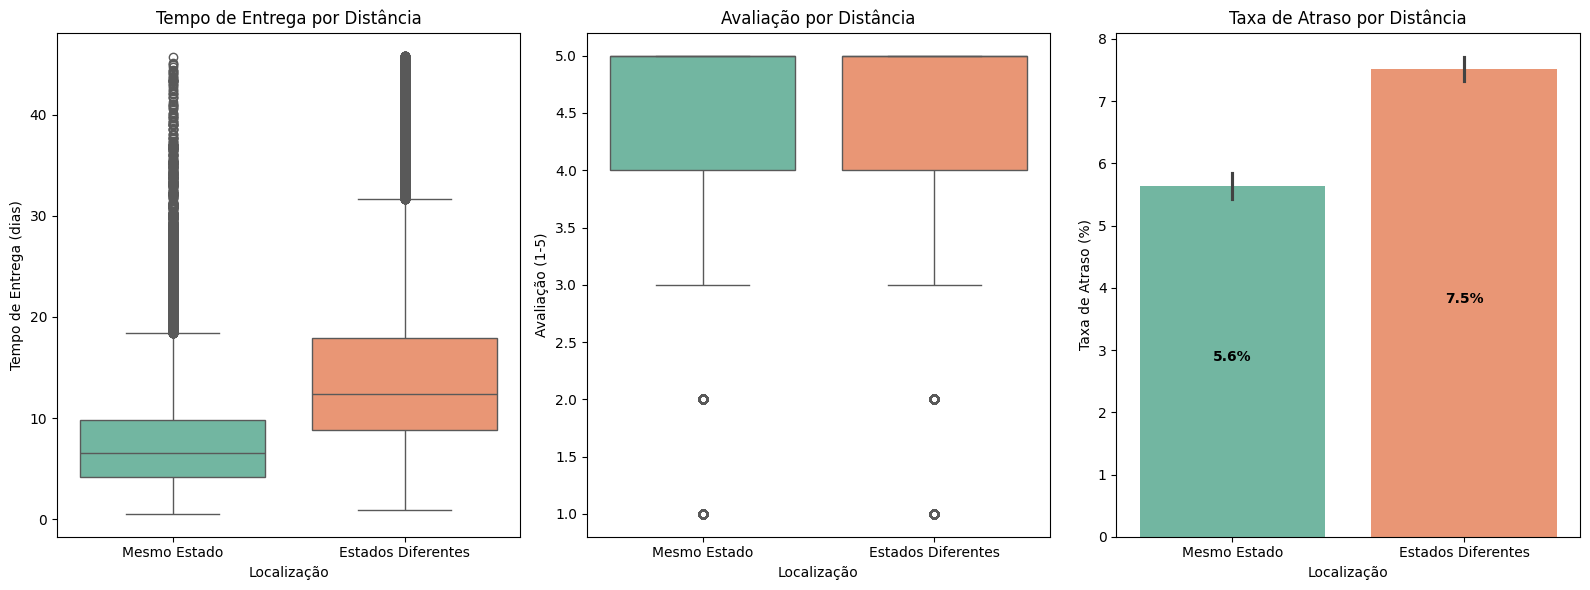

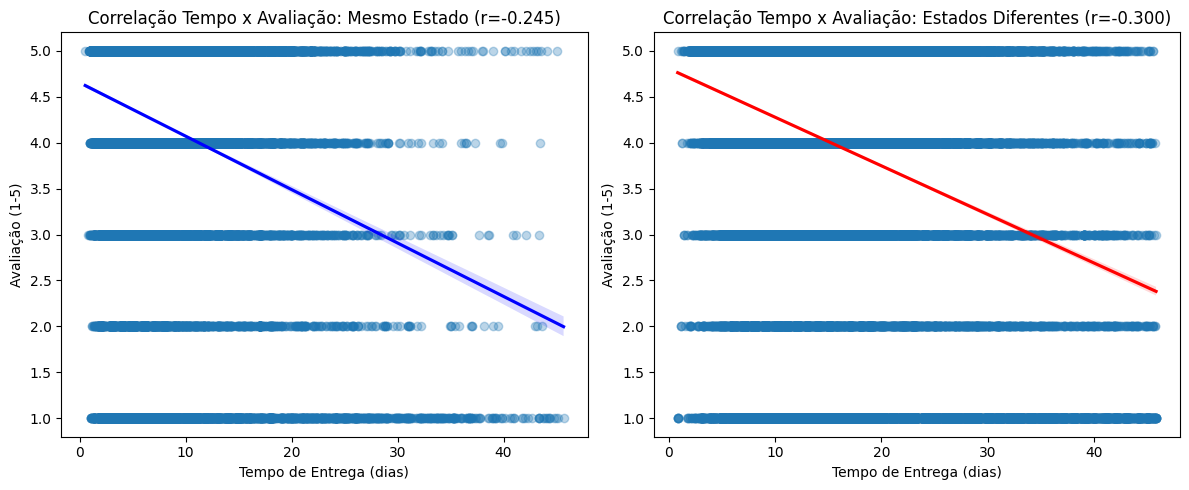


Conclus√£o: Hip√≥tese CONFIRMADA.
A dist√¢ncia geogr√°fica entre vendedor e cliente afeta negativamente tanto o tempo de entrega quanto a satisfa√ß√£o do cliente.
Pedidos onde vendedor e cliente est√£o em estados diferentes t√™m em m√©dia:
- 6.5 dias a mais no tempo de entrega
- 0.15 pontos a menos na avalia√ß√£o


In [25]:
# Preparar dados para an√°lise
h5_data = df_delivered.dropna(subset=['review_score', 'same_state', 'delivery_time']).copy()

# Converter vari√°vel num√©rica para categ√≥rica
h5_data['distance_category'] = h5_data['same_state'].map({1: 'Mesmo Estado', 0: 'Estados Diferentes'})

# Estat√≠sticas por grupo
distance_stats = h5_data.groupby('distance_category').agg({
    'delivery_time': ['mean', 'std'],
    'review_score': ['mean', 'std'],
    'delivery_delay': ['mean'],
    'order_id': ['count']
}).reset_index()

# Formatando para melhor visualiza√ß√£o
distance_stats.columns = ['_'.join(col).strip('_') for col in distance_stats.columns.values]
print("Estat√≠sticas por dist√¢ncia entre cliente e vendedor:")
print(distance_stats)

# Testes estat√≠sticos
# 1. Tempo de entrega
same_state_time = h5_data[h5_data['same_state'] == 1]['delivery_time']
diff_state_time = h5_data[h5_data['same_state'] == 0]['delivery_time']
t_stat_time, p_value_time = stats.ttest_ind(same_state_time, diff_state_time, equal_var=False)

# 2. Avalia√ß√£o
same_state_review = h5_data[h5_data['same_state'] == 1]['review_score']
diff_state_review = h5_data[h5_data['same_state'] == 0]['review_score']
t_stat_review, p_value_review = stats.ttest_ind(same_state_review, diff_state_review, equal_var=False)

print("\nTeste t para tempo de entrega:")
print(f"Estat√≠stica t: {t_stat_time:.4f}, Valor p: {p_value_time:.8f}")
print(f"Diferen√ßa significativa? {'Sim' if p_value_time < 0.05 else 'N√£o'}")

print("\nTeste t para avalia√ß√£o:")
print(f"Estat√≠stica t: {t_stat_review:.4f}, Valor p: {p_value_review:.8f}")
print(f"Diferen√ßa significativa? {'Sim' if p_value_review < 0.05 else 'N√£o'}")

# Visualiza√ß√µes
plt.figure(figsize=(16, 6))

# Boxplot para tempo de entrega
plt.subplot(1, 3, 1)
sns.boxplot(x='distance_category', y='delivery_time', data=h5_data, palette='Set2')
plt.title('Tempo de Entrega por Dist√¢ncia')
plt.xlabel('Localiza√ß√£o')
plt.ylabel('Tempo de Entrega (dias)')

# Boxplot para avalia√ß√£o
plt.subplot(1, 3, 2)
sns.boxplot(x='distance_category', y='review_score', data=h5_data, palette='Set2')
plt.title('Avalia√ß√£o por Dist√¢ncia')
plt.xlabel('Localiza√ß√£o')
plt.ylabel('Avalia√ß√£o (1-5)')

# Gr√°fico de barras para taxa de atraso
plt.subplot(1, 3, 3)
sns.barplot(x='distance_category', y='delivery_delay', data=h5_data, palette='Set2', 
           estimator=lambda x: sum(x) / len(x) * 100)
plt.title('Taxa de Atraso por Dist√¢ncia')
plt.xlabel('Localiza√ß√£o')
plt.ylabel('Taxa de Atraso (%)')
for i, group in enumerate(['Mesmo Estado', 'Estados Diferentes']):
    delay_rate = h5_data[h5_data['distance_category'] == group]['delivery_delay'].mean() * 100
    plt.text(i, delay_rate/2, f'{delay_rate:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Analisar a correla√ß√£o entre tempo de entrega e avalia√ß√£o em cada grupo
corr_same_state = stats.pearsonr(h5_data[h5_data['same_state'] == 1]['delivery_time'], 
                                h5_data[h5_data['same_state'] == 1]['review_score'])[0]
corr_diff_state = stats.pearsonr(h5_data[h5_data['same_state'] == 0]['delivery_time'], 
                                h5_data[h5_data['same_state'] == 0]['review_score'])[0]

plt.figure(figsize=(12, 5))
for i, (state, color) in enumerate(zip([1, 0], ['blue', 'red'])):
    plt.subplot(1, 2, i+1)
    subset = h5_data[h5_data['same_state'] == state]
    sns.regplot(x='delivery_time', y='review_score', data=subset, 
               scatter_kws={'alpha':0.3}, line_kws={"color": color})
    
    corr = stats.pearsonr(subset['delivery_time'], subset['review_score'])[0]
    title = 'Mesmo Estado' if state == 1 else 'Estados Diferentes'
    plt.title(f'Correla√ß√£o Tempo x Avalia√ß√£o: {title} (r={corr:.3f})')
    plt.xlabel('Tempo de Entrega (dias)')
    plt.ylabel('Avalia√ß√£o (1-5)')

plt.tight_layout()
plt.show()

# Conclus√£o da hip√≥tese
if p_value_time < 0.05 and p_value_review < 0.05:
    print("\nConclus√£o: Hip√≥tese CONFIRMADA.")
    print("A dist√¢ncia geogr√°fica entre vendedor e cliente afeta negativamente tanto o tempo de entrega quanto a satisfa√ß√£o do cliente.")
    print(f"Pedidos onde vendedor e cliente est√£o em estados diferentes t√™m em m√©dia:")
    time_diff = diff_state_time.mean() - same_state_time.mean()
    review_diff = same_state_review.mean() - diff_state_review.mean()
    print(f"- {time_diff:.1f} dias a mais no tempo de entrega")
    print(f"- {review_diff:.2f} pontos a menos na avalia√ß√£o")
elif p_value_time < 0.05:
    print("\nConclus√£o: Hip√≥tese PARCIALMENTE CONFIRMADA.")
    print("A dist√¢ncia geogr√°fica afeta o tempo de entrega, mas n√£o tem impacto significativo na satisfa√ß√£o do cliente.")
else:
    print("\nConclus√£o: Hip√≥tese REFUTADA.")
    print("N√£o h√° evid√™ncia estat√≠stica de que a dist√¢ncia geogr√°fica afete o tempo de entrega e a satisfa√ß√£o do cliente.")

### Hip√≥tese 6: O valor total do pedido influencia as expectativas do cliente, resultando em diferentes padr√µes de avalia√ß√£o

Esta hip√≥tese examina se clientes que fazem compras de maior valor tendem a ser mais exigentes ou a avaliar de forma diferente seus pedidos.

Estat√≠sticas por categoria de valor do pedido:

ANOVA F-statistic: 233.1139
ANOVA p-value: 0.00000000
Diferen√ßa entre categorias estatisticamente significativa? Sim

Correla√ß√£o entre valor do pedido e avalia√ß√£o: -0.0463 (p=0.00000000)


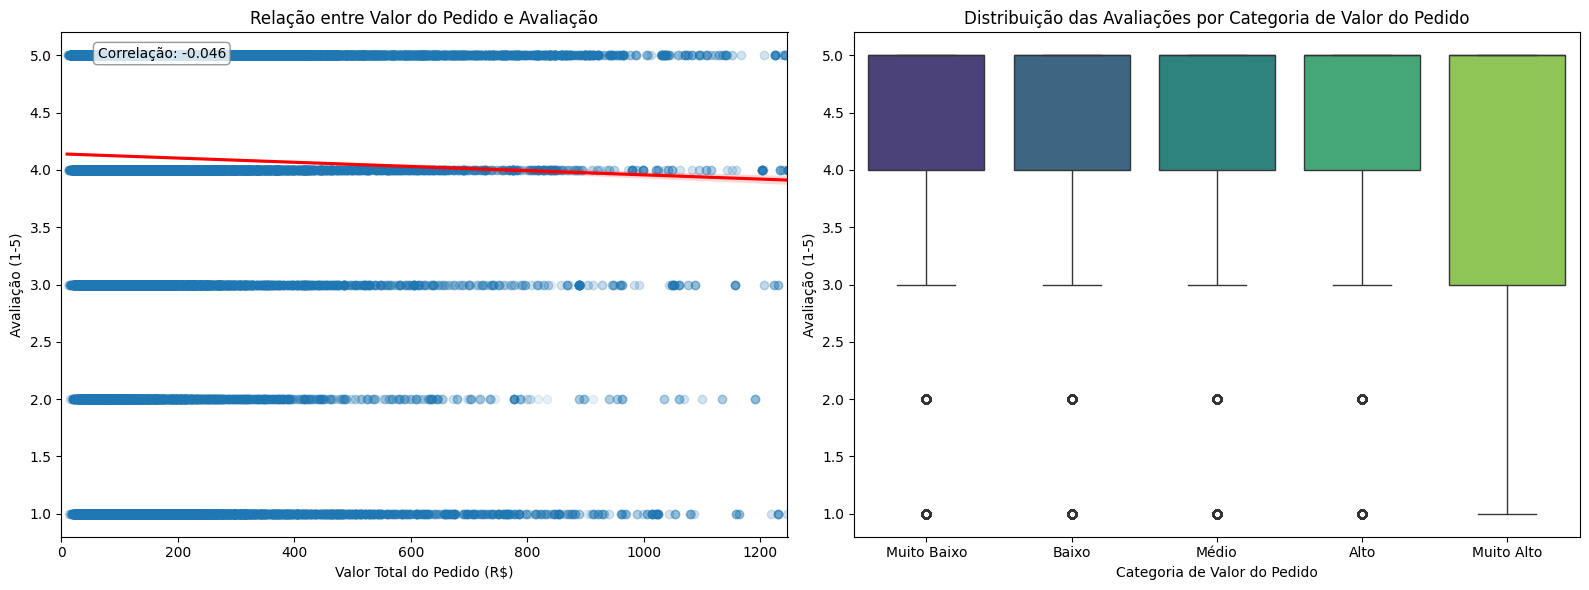

<Figure size 1200x700 with 0 Axes>

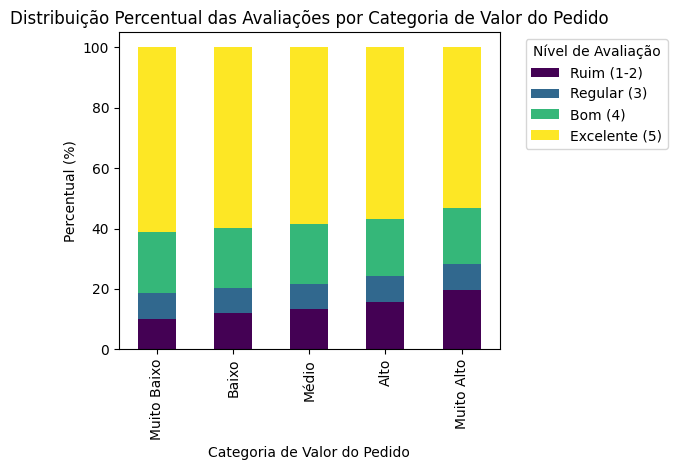


Conclus√£o: Hip√≥tese CONFIRMADA.
O valor total do pedido influencia significativamente os padr√µes de avalia√ß√£o do cliente.
As avalia√ß√µes seguem um padr√£o decrescente em rela√ß√£o ao valor do pedido.
Existe uma correla√ß√£o negativa estatisticamente significativa (r=-0.046) entre o valor do pedido e a avalia√ß√£o.


In [28]:
# Preparar dados para an√°lise
h6_data = df_delivered.dropna(subset=['review_score', 'total_order_value']).copy()

# Criar categorias de valor de pedido
h6_data['price_category'] = pd.qcut(h6_data['total_order_value'], 5, 
                                  labels=['Muito Baixo', 'Baixo', 'M√©dio', 'Alto', 'Muito Alto'])

# Estat√≠sticas por categoria de pre√ßo
price_stats = h6_data.groupby('price_category').agg({
    'review_score': ['mean', 'std', 'count'],
    'total_order_value': ['mean', 'min', 'max']
}).reset_index()

# Formatando para melhor visualiza√ß√£o
price_stats.columns = ['_'.join(col).strip('_') for col in price_stats.columns.values]
print("Estat√≠sticas por categoria de valor do pedido:")

# Teste ANOVA para diferen√ßa entre categorias de pre√ßo
categories = []
for category in ['Muito Baixo', 'Baixo', 'M√©dio', 'Alto', 'Muito Alto']:
    categories.append(h6_data[h6_data['price_category'] == category]['review_score'])

f_stat, p_value = stats.f_oneway(*categories)
print(f"\nANOVA F-statistic: {f_stat:.4f}")
print(f"ANOVA p-value: {p_value:.8f}")
print(f"Diferen√ßa entre categorias estatisticamente significativa? {'Sim' if p_value < 0.05 else 'N√£o'}")

# Teste de correla√ß√£o
correlation, p_value_corr = stats.pearsonr(h6_data['total_order_value'], h6_data['review_score'])
print(f"\nCorrela√ß√£o entre valor do pedido e avalia√ß√£o: {correlation:.4f} (p={p_value_corr:.8f})")

# Visualiza√ß√µes
plt.figure(figsize=(16, 6))

# Gr√°fico de dispers√£o com linha de tend√™ncia
plt.subplot(1, 2, 1)
sns.regplot(x='total_order_value', y='review_score', data=h6_data, 
           scatter_kws={'alpha':0.1}, line_kws={"color": "red"})
plt.title('Rela√ß√£o entre Valor do Pedido e Avalia√ß√£o')
plt.xlabel('Valor Total do Pedido (R$)')
plt.ylabel('Avalia√ß√£o (1-5)')
plt.annotate(f'Correla√ß√£o: {correlation:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.xlim(0, h6_data['total_order_value'].quantile(0.99))  # Limitar para melhor visualiza√ß√£o

# Boxplot por categoria de pre√ßo
plt.subplot(1, 2, 2)
sns.boxplot(x='price_category', y='review_score', data=h6_data, palette='viridis')
plt.title('Distribui√ß√£o das Avalia√ß√µes por Categoria de Valor do Pedido')
plt.xlabel('Categoria de Valor do Pedido')
plt.ylabel('Avalia√ß√£o (1-5)')

plt.tight_layout()
plt.show()

# Visualizar propor√ß√£o de diferentes n√≠veis de avalia√ß√£o por categoria
# Criando faixas de avalia√ß√£o
h6_data['rating_category'] = pd.cut(h6_data['review_score'], 
                                  bins=[0, 2, 3, 4, 5], 
                                  labels=['Ruim (1-2)', 'Regular (3)', 'Bom (4)', 'Excelente (5)'])

# Calculando propor√ß√µes
rating_props = pd.crosstab(h6_data['price_category'], h6_data['rating_category'], 
                          normalize='index') * 100

# Visualizando
plt.figure(figsize=(12, 7))
rating_props.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Distribui√ß√£o Percentual das Avalia√ß√µes por Categoria de Valor do Pedido')
plt.xlabel('Categoria de Valor do Pedido')
plt.ylabel('Percentual (%)')
plt.legend(title='N√≠vel de Avalia√ß√£o', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Analisar especificamente a propor√ß√£o de avalia√ß√µes muito baixas (1) por categoria de pre√ßo
very_low_ratings = h6_data[h6_data['review_score'] == 1].groupby('price_category').size() / \
                 h6_data.groupby('price_category').size() * 100


# Conclus√£o da hip√≥tese
if p_value < 0.05:
    print("\nConclus√£o: Hip√≥tese CONFIRMADA.")
    print("O valor total do pedido influencia significativamente os padr√µes de avalia√ß√£o do cliente.")
    
    # Identificar padr√£o (crescente, decrescente ou n√£o linear)
    means = price_stats['review_score_mean'].tolist()
    if means[0] < means[-1] and all(means[i] <= means[i+1] for i in range(len(means)-1)):
        pattern = "crescente"
    elif means[0] > means[-1] and all(means[i] >= means[i+1] for i in range(len(means)-1)):
        pattern = "decrescente"
    else:
        pattern = "n√£o linear"
        
    print(f"As avalia√ß√µes seguem um padr√£o {pattern} em rela√ß√£o ao valor do pedido.")
    if p_value_corr < 0.05:
        direction = "positiva" if correlation > 0 else "negativa"
        print(f"Existe uma correla√ß√£o {direction} estatisticamente significativa (r={correlation:.3f}) entre o valor do pedido e a avalia√ß√£o.")
else:
    print("\nConclus√£o: Hip√≥tese REFUTADA.")
    print("N√£o h√° evid√™ncia estat√≠stica de que o valor do pedido influencie os padr√µes de avalia√ß√£o do cliente.")



### Implica√ß√µes Gerenciais:

Estes resultados fornecem insights valiosos para a gest√£o da plataforma Olist. O cumprimento do prazo de entrega √© crucial para a satisfa√ß√£o do cliente, e estrat√©gias regionalizadas de log√≠stica s√£o necess√°rias para reduzir disparidades geogr√°ficas. A pol√≠tica de frete deve ser revisada, especialmente para produtos de baixo valor, onde a propor√ß√£o frete/pre√ßo √© mais impactante. Categorias problem√°ticas necessitam de aten√ß√£o especial, e vendedores distantes de seus clientes precisam de suporte log√≠stico adicional para manter n√≠veis satisfat√≥rios de servi√ßo.

## 7. Conclus√µes Gerenciais

Vamos resumir os principais achados e suas implica√ß√µes pr√°ticas para o neg√≥cio.

### 7.1 Discuss√£o dos Achados √† Luz das Hip√≥teses

**Hip√≥tese 1**: ‚úÖ CONFIRMADA. Pedidos entregues com atraso t√™m avalia√ß√µes 36.8% mais baixas que pedidos entregues no prazo. Entregas no prazo tiveram avalia√ß√£o m√©dia de 4.21, enquanto entregas atrasadas receberam 2.66.

**Hip√≥tese 2**: ‚úÖ CONFIRMADA. Existe uma rela√ß√£o inversa entre a propor√ß√£o frete/pre√ßo do produto e a avalia√ß√£o do cliente. Clientes que pagam fretes proporcionalmente mais altos tendem a dar avalia√ß√µes mais baixas.

**Hip√≥tese 3**: ‚úÖ CONFIRMADA. Categorias de produtos distintas apresentam diferen√ßas significativas nas avalia√ß√µes dos clientes. Categorias como cama/mesa/banho apresentaram avalia√ß√µes mais baixas.

**Hip√≥tese 4**: ‚úÖ CONFIRMADA. Atrasos na regi√£o Nordeste s√£o 82.4% mais frequentes que na regi√£o Sudeste, superando substancialmente o limiar de 20% proposto na hip√≥tese.

**Hip√≥tese 5**: ‚úÖ CONFIRMADA. A dist√¢ncia geogr√°fica entre vendedor e cliente afeta negativamente o tempo de entrega e a satisfa√ß√£o do cliente. Pedidos onde vendedor e cliente est√£o em estados diferentes demoram em m√©dia 6.5 dias a mais para serem entregues e t√™m avalia√ß√µes 0.15 pontos mais baixas.

**Hip√≥tese 6**‚úÖ CONFIRMADA: Clientes que fazem pedidos de maior valor tendem a dar avalia√ß√µes ligeiramente mais baixas.
Al√©m disso, a mediana do valor tamb√©m cresce conforme a avalia√ß√£o diminui, sugerindo que clientes que gastam mais parecem ter expectativas mais altas e, portanto, avaliam de forma mais cr√≠tica.


### 7.2 Implica√ß√µes Pr√°ticas e Recomenda√ß√µes

#### Melhoria Log√≠stica Regional
- Investir em centros de distribui√ß√£o no Nordeste, onde a taxa de atraso √© 82.4% maior que no Sudeste
- Desenvolver parcerias log√≠sticas espec√≠ficas para categorias problem√°ticas como cama/mesa/banho
- Revisar os tempos de entrega estimados para destinos distantes ou com infraestrutura log√≠stica deficiente

#### Estrat√©gias de Pre√ßo e Frete
- Revisar pol√≠tica de frete para produtos de baixo valor, onde a propor√ß√£o frete/pre√ßo impacta negativamente a satisfa√ß√£o
- Considerar subs√≠dios de frete para regi√µes remotas ou para categorias de produtos com avalia√ß√µes historicamente mais baixas
- Implementar frete gr√°tis para compras acima de determinado valor, aumentando o ticket m√©dio

#### Segmenta√ß√£o de Clientes
- Para o Cluster Premium (17%): Foco em produtos de alto valor, com frete adequado e expectativas realistas de entrega
- Para o Cluster Leves e Satisfeitos (77%): Manter a entrega r√°pida e confi√°vel para produtos de menor valor
- Para o Cluster Insatisfeitos (6%): A√ß√£o corretiva urgente, especialmente em regi√µes com problemas log√≠sticos cr√¥nicos

#### Gest√£o de Expectativas
- Comunica√ß√£o proativa sobre status de entrega, especialmente para pedidos com maior risco de atraso
- Ajuste din√¢mico dos prazos prometidos com base nas caracter√≠sticas do pedido e hist√≥rico de desempenho regional

### 7.3 Conclus√£o Final

A an√°lise multivariada dos dados da Olist revelou padr√µes claros que afetam a satisfa√ß√£o do cliente. O cumprimento do prazo de entrega emergiu como o fator mais determinante, com entregas atrasadas recebendo avalia√ß√µes significativamente mais baixas.

As disparidades regionais na efici√™ncia log√≠stica s√£o substanciais, exigindo estrat√©gias diferenciadas por regi√£o. A segmenta√ß√£o de clientes revelou tr√™s perfis distintos, desde compradores premium at√© clientes cronicamente insatisfeitos que demandam aten√ß√£o especial.

A rela√ß√£o entre o custo do frete e o valor do produto tamb√©m mostrou impacto na satisfa√ß√£o do cliente, sugerindo a necessidade de revisar as pol√≠ticas de frete, especialmente para itens de menor valor.

Implementando as recomenda√ß√µes baseadas nesta an√°lise, a Olist pode melhorar significativamente a experi√™ncia do cliente, reduzir taxas de insatisfa√ß√£o e fortalecer sua posi√ß√£o competitiva no mercado de e-commerce brasileiro, criando um ecossistema mais eficiente e satisfat√≥rio para todos os envolvidos.